In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings

# PyTorch and related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Scikit-learn
from sklearn.datasets import fetch_openml, load_breast_cancer, load_diabetes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Deep learning and transformers
import timm
from transformers import pipeline

# Custom helper functions
from helper import (
    # Neural network functions
    SimpleMLP, SimpleLinearRegression, SimpleCNN, fit_model,
    interactive_relu_demo, approximate_function, plot_function_approximation,
    simple_sine_dataset, plot_function_fit, train_model,
    
    # Visualization helpers
    plot_decision_boundary_evolution, plot_training_loss, compare_learning_rates,
    plot_mnist, plot_multiple_epochs, plot_single_epoch,
    extract_and_plot_feature_maps, visualize_cnn_representations,
    plot_rmse_loss_surface_with_arrow, visualize_decision_boundary,
    visualize_layer_transformations,
    
    # Data generation and preprocessing
    create_nested_circles_data, downsample_history, generate_moons_data,
    generate_regression, get_sample, prepare_mnist, prepare_data_for_mlp,
    loadChestMNIST,
    
    # Model comparison
    compare_regression_models, compare_classification_models
)
from helper import loadPneumoniaMNIST
from helper import visualize_model_representations
from helper import evaluate_classification_model
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from helper import train_language_model
from helper import prepare_data_for_textAnalysis

warnings.filterwarnings('ignore')


# Notes

- definitely also leave this website somewhere in the notebook https://playground.tensorflow.org/
- todo remove the loss plots and show them later
- breakup the code parts
- maybe add torchinfo
- maybe we can animate the weights like this https://ml-visualized.com/chapter4/neural_network_weights
- i had a bit of trouble animating gradient descent with this https://aero-learn.imperial.ac.uk/vis/Machine%20Learning/gradient_descent_3d.html, leave it for now
- todo improve gradient descent plots
- go over the code to split it up in more feasible parts
- I didn't introduce early stopping now, I think it would make sense to maybe talk about regularization in neural nets (dropout early stopping etc.) seperately but aswell, maybe we can combine it with hyperparameter tuning, because there i have just done 1 plot for different learning rates
- maybe also introduce things like weight-decay, learning rate scheduling, momentum?
- do we want to compare the nn's with other methods for regression, classification etc? and then we could also do cross-validation however that would take some time to compute (especially since we probably don't have gpu's)
- maybe we can think about other medical datasets, since I again used Breast cancer(because of it's simplicity and familiarity for the students)
- My Laptop is too weak for transfer learning, can't fine-tune a resnet18, maybe there's a smaller one -> mobilenet/efficientnet
- TODO: update values after finishing everything


# Table of Contents

<br><br>
# **Hands-On: Deep Learning Fundamentals**

## Why This Matters for Healthcare

Neural networks are revolutionizing medical practice:
- **Medical imaging**: Detecting cancer in radiology scans with superhuman accuracy
- **Drug discovery**: Accelerating the development of new treatments
- **Clinical decision support**: Predicting patient outcomes and treatment responses
- **Electronic health records**: Extracting insights from complex patient data

**This session will demystify the technology** behind these breakthroughs and show you how neural networks actually work.

## Learning Goals

By the end of this session, you will:

### **Understand How Neural Networks Think**
- Grasp the core concept: how simple mathematical functions combine to recognize complex patterns
- See why networks can learn any relationship in your data (Universal Approximation Theorem)

### TODO add more learning goals here

---

**No advanced math required** – we focus on intuition and practical understanding!

## What is a Neural Network?

A **neural network** is a computational model inspired by how biological neurons process information. At its core, it's a collection of interconnected nodes (neurons) that:

1. **Receive inputs** (like features from data)
2. **Apply weights** to these inputs (learned parameters)
3. **Add a bias term** (learned offset)
4. **Pass through an activation function** (introduces non-linearity)
5. **Produce an output** that feeds into the next layer

**Key components:**
- **Weights**: Determine the strength of connections between neurons
- **Biases**: Allow neurons to activate even when inputs are zero
- **Activation functions**: Non-linear functions (like ReLU, sigmoid, tanh) that enable networks to learn complex patterns

<img src="imgs/relu_nn.webp" alt="Neural Network Diagram" width="500"/>



## Why Neural Networks Are So Powerful

Here's the remarkable thing: **neural networks can learn to recognize ANY pattern** in your data, no matter how complex. This is backed by a fundamental mathematical principle:

> **The Universal Approximation Theorem**: Any continuous relationship can be learned by a neural network with enough neurons.

Let's see the magic in action by building complex functions from simple building blocks.



## Building Complex Patterns from Simple Parts

We'll demonstrate this using **ReLU (Rectified Linear Unit)** functions - the most common building block in modern neural networks.

**ReLU function**: `ReLU(x) = max(0, x)` - outputs the input if positive, zero otherwise.

The magic happens when we:
1. **Shift** ReLU functions to different positions
2. **Scale** them with different weights  
3. **Combine** multiple ReLUs together

Let's see how these simple "on/off" functions can create surprisingly complex patterns:

In [2]:
interactive_relu_demo()

interactive(children=(FloatSlider(value=1.0, description='Weight 1:', layout=Layout(width='300px'), max=2.0, m…

You can see how just changing the **weight** (slope) and **bias** (shift) parameters creates completely different function shapes. This is the key insight:

- **Weight** controls how steep the ReLU ramp is
- **Bias** controls where the ReLU "turns on" (shifts the corner left/right)
- **Combining multiple ReLUs** with different weights and biases lets us build complex, piecewise-linear functions

Now you understand the building blocks! But can we really approximate **any** function? Let's put this to the test with a challenging target: **the sine function**.

The sine function is smooth and curved - quite different from the sharp, linear segments of ReLU functions. Yet the Universal Approximation Theorem tells us we can get arbitrarily close using enough ReLUs.

In [3]:
# Generate training data from sine function
x_train, y_train = simple_sine_dataset(N=10)

In [4]:
# Approximate the function
y_hat, relu_acts, x, combination_weights = approximate_function(x_train, y_train)

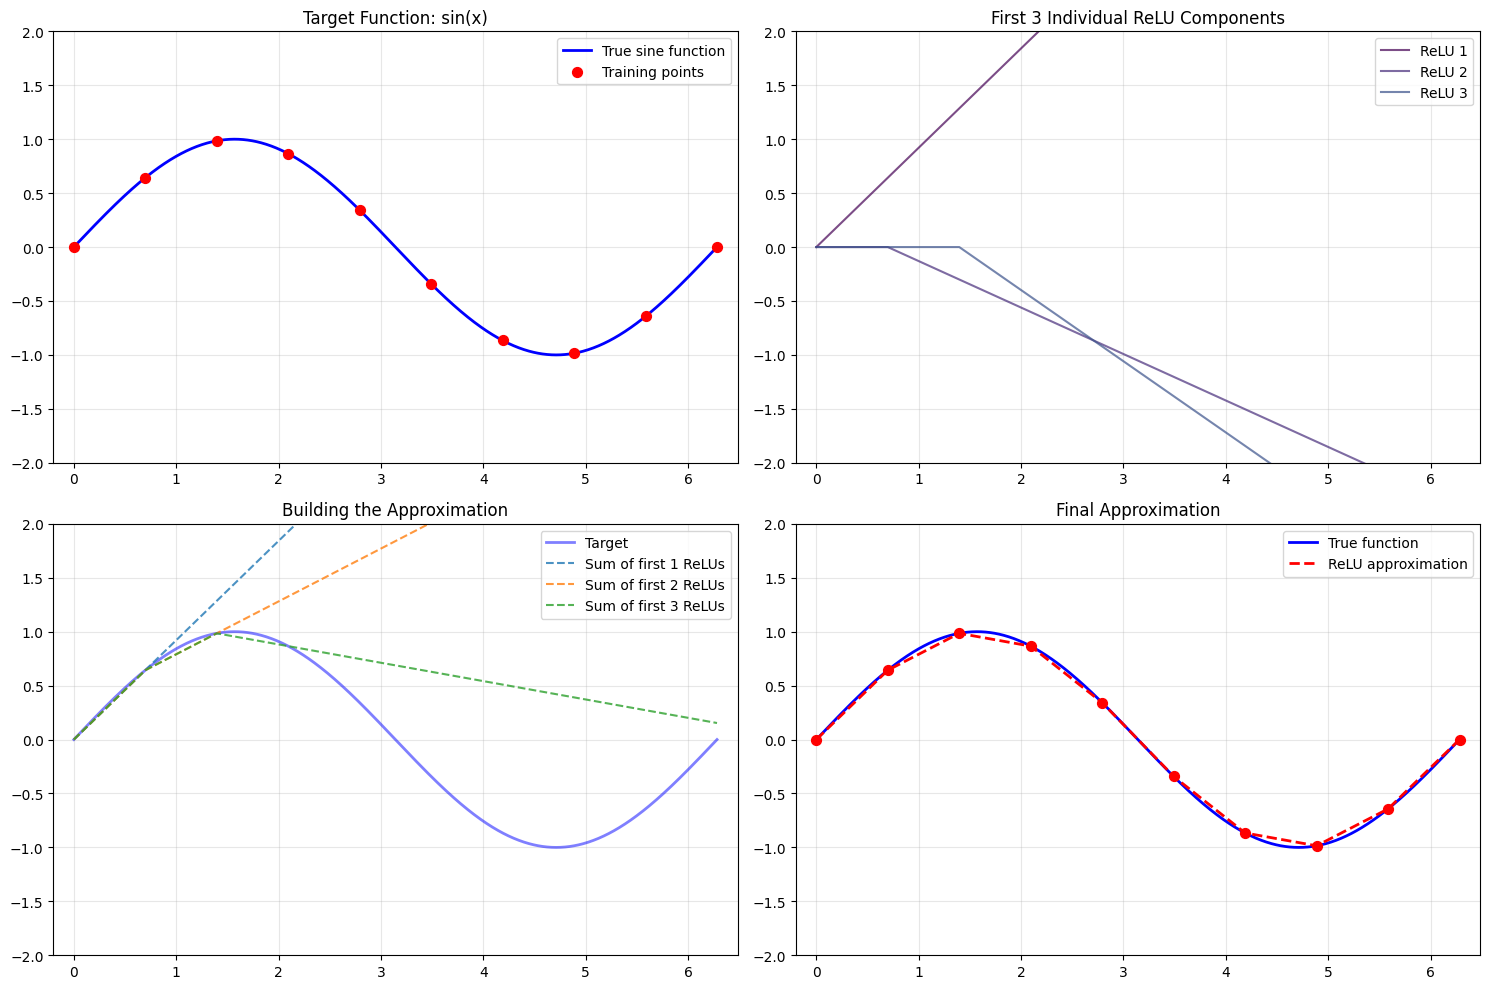

In [5]:
# Visualize the approximation process
plot_function_approximation(x_train, y_train, x, relu_acts, y_hat, combination_weights)

Our ReLU approximation captures the sine wave's shape quite well, even with just 9 ReLU functions (from 10 training points). 

- The approximation follows the general sine curve structure  
- It perfectly matches at all training points (red dots)
- The piecewise-linear nature creates small "corners" but the overall shape is preserved

## Building MLPs with PyTorch

**What we just accomplished**: We manually engineered a function approximator using mathematical formulas and ReLU building blocks.

**What we'll do now**: Build the same thing using **PyTorch**

**Multilayer Perceptron (MLP)** is the formal name for the type of neural network we've been exploring:
- **Input layer**: Receives data
- **Hidden layer(s)**: Transform data using weights, biases, and activation functions (like ReLU)
- **Output layer**: Produces final predictions

MLPs are also called **feedforward neural networks** or **fully connected networks** - they're the foundation that more complex architectures (some we will explore later) build upon.

Let's start with the simplest possible example - a simple MLP that learns to approximate our sine function.

In [6]:
# Create a simple powerful network that has 32 hidden neurons
mlp = SimpleMLP(input_size=1, hidden_size=32, output_size=1, num_layers=2)

In [7]:
# Generate training data from sine function
x_train, y_train = simple_sine_dataset(N=100)

# Train the model (we'll dive into how this works later!)
losses = fit_model(mlp, x_train, y_train)

In [8]:
y_pred = mlp(x_train).detach()

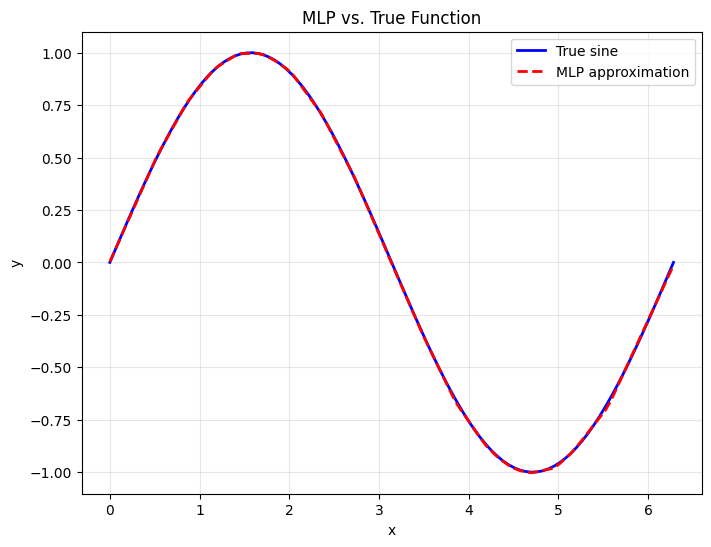

Final loss: 0.000019


In [9]:
plot_function_fit(x_train, y_train, y_pred, losses)

## From Function Approximation to Classification

We just built neural networks that learn continuous functions. But MLPs can do much more than approximate sine waves.

Let's tackle a more challenging example. **Can a neural network learn to distinguish between points in an inner circle vs. an outer ring?**

This demonstrates how neural networks transform simple 2D coordinates into complex decision boundaries.

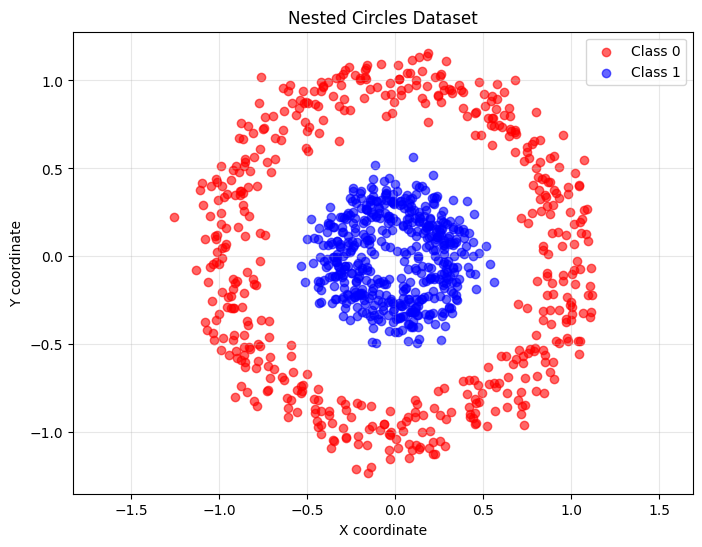

In [10]:
# Create dataset
X_train, y_train = create_nested_circles_data(1000)


Now let's define a slightly more complex MLP with **two hidden layers** to tackle this circular classification problem:

**Key differences from our sine function MLP:**
- **Input size**: 2 (x and y coordinates instead of just x)
- **Output size**: 2 (probability for each class: inner circle vs outer ring) (TODO Maybe adjust this to 1 output with sigmoid function)
- **Two hidden layers**: More capacity to learn complex patterns

**Custom functionality**: We've added a special `get_representations()` function to our MLP that returns the intermediate representations learned by each layer. This allows us to visualize how the network transforms the data step-by-step - we'll use this to see how patterns emerge!

In [11]:
model = SimpleMLP(input_size=2, hidden_size=20, output_size=2, num_layers=2)

In [12]:
# Train the model
losses = fit_model(model, X_train, y_train, epochs=1000, type='classification')

After training our model, let's investigate what it actually learned. We can visualize the **decision boundary** by coloring the entire space based on which class the model predicts is more probable at each point.

**Red regions**: Model predicts "outer circle" (Class 0)  
**Blue regions**: Model predicts "inner ring" (Class 1)

This will reveal whether our MLP successfully learned the circular pattern!

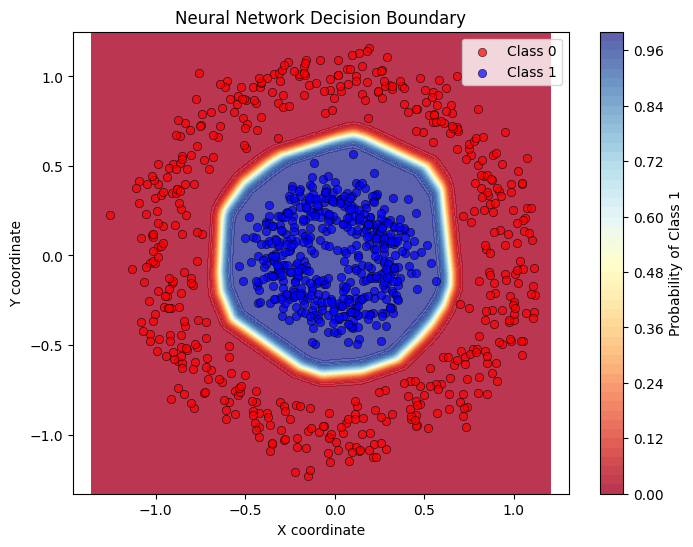

In [13]:
# Visualize results
visualize_decision_boundary(model, X_train.numpy(), y_train.numpy())

The neural network successfully discovered the circular decision boundary. Notice how the model creates a smooth transition zone (orange/yellow) between the two classes.

## Investigating What the Model Learned at Each Step

But how did the network transform simple (x, y) coordinates into this complex circular pattern? We can investigate what our model learned at each hidden layer by examining the **intermediate representations**.

Our approach is to use **Multidimensional Scaling (MDS)** to reduce the high-dimensional hidden layer activations down to 2D for visualization. This will show us how the data gets progressively transformed as it flows through each layer of the network.

Let's trace the journey from input coordinates to final classification!

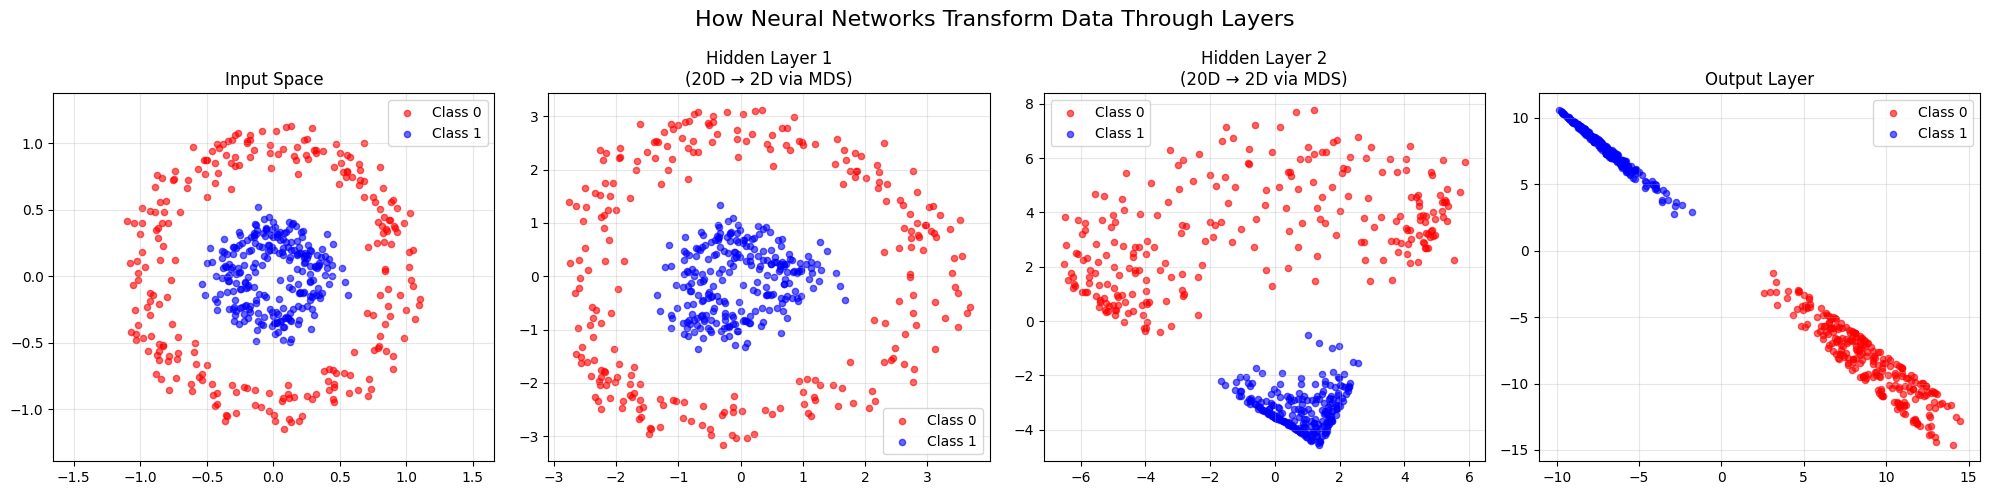

In [14]:
# Use the new function visualize_model_representations
visualize_layer_transformations(model, X_train, y_train)

This plot beautifully visualizes how the MLP learns to **progressively transform** the data representation to make it linearly separable:

- **Input Space**: Circular pattern - impossible to separate with a straight line
- **Hidden Layer 1**: Network begins to "stretch" and distort the circular boundary
- **Hidden Layer 2**: Classes become more separated, but still curved
- **Output Layer**: **Perfect linear separation!** The two classes form distinct diagonal lines

Neural networks solve complex problems by learning to **transform the data** into new representations where simple solutions (like straight lines) become possible. This is the essence of deep learning - finding the right representation.

---
<br><br>
# How Neural Networks Actually Learn: Gradient Descent and Backpropagation

How does the network figure out the right transformations? 

We've seen neural networks perform amazing feats - approximating sine functions and learning circular decision boundaries. But we haven't explained the **learning mechanism** itself. How does the network know which weights to adjust and by how much?

The answer lies in two fundamental algorithms that power all of deep learning:
- **Gradient Descent**: The optimization strategy
- **Backpropagation**: The method for computing gradients

Let's dive into the mathematical engine that makes neural network learning possible.

## Gradient Descent

Let's understand **gradient descent** with the simplest possible example: fitting a straight line to data.

We have some data points and want to find the best line `y = mx + b` that fits them. We'll start with **random** values for slope (m) and intercept (b), then watch gradient descent automatically improve them. This is basically what we did in the chapter on optimization methods in the first Notebook.

As we know, Linear regression has a **closed-form solution**. However, for more complex problems like neural networks, closed-form solutions don't exist. That's why we introduce gradient descent with this simple example first, even though we could solve it directly.

**Intuition**: Gradient descent is like being blindfolded on a hill and trying to reach the bottom. You feel the slope under your feet and take steps in the steepest downward direction.

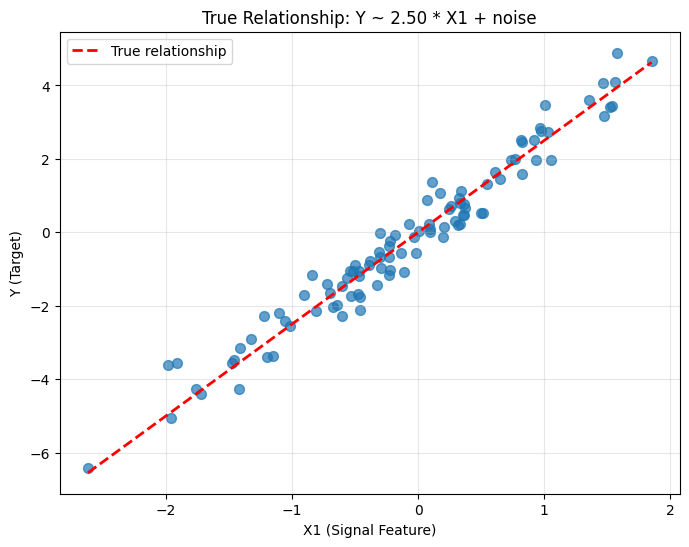

In [15]:
X, y_true, _ = generate_regression(n_samples=100, n_features=1, coef=[2.5], noise=0.5, test_data=False)

In [16]:
# Convert to tensors
X_tensor = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y_true.reshape(-1, 1), dtype=torch.float32)

We are using `SimpleLinearRegression` to show how to train a pytorch model using gradient descent.

In [17]:
# Create model and optimizer
lr = 0.1
model = SimpleLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

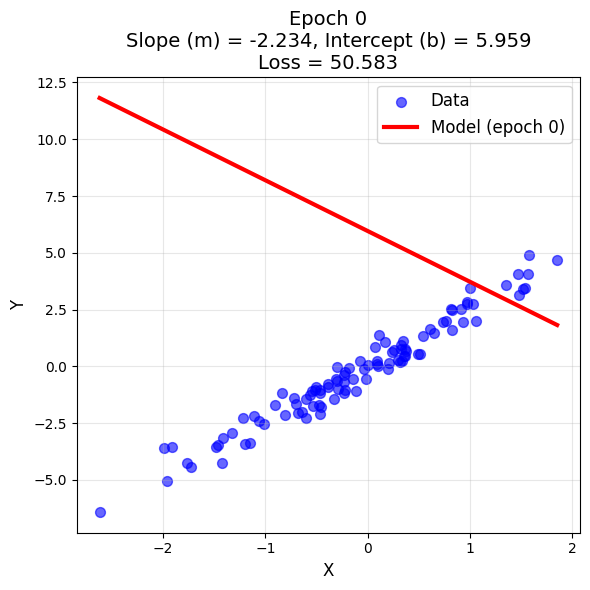

In [18]:
# Initial state - before any training
w0_hist = []  # bias (intercept) history
w1_hist = []  # weight (slope) history  
rmse_hist = []  # RMSE history

y_pred = model(X_tensor)
initial_loss = criterion(y_pred, y_tensor)

w0_hist.append(model.linear.bias.item())
w1_hist.append(model.linear.weight.item())
rmse_hist.append(np.mean((y_true - model.linear.bias.item() + model.linear.weight.item() * X) ** 2))

plot_single_epoch(X, y_true, 0, 
                  model.linear.weight.item(), 
                  model.linear.bias.item(), 
                  initial_loss.item())

Above we see our **randomly initialized** model at the start (epoch 0). The red line shows our initial guess:

TODO: update values after finishing everything

- **Slope (m)** = -2.234 
- **Intercept (b)** = 10.959
- **Loss** = 872.666

This is clearly a terrible fit! The line goes in completely the wrong direction compared to our data points. But that's exactly the point - gradient descent will fix this automatically.

## How Gradient Descent Works

Now we'll perform **one iteration** of gradient descent to see how the algorithm improves our model:

1. **Calculate the gradient**: For each parameter (slope and intercept), we compute how much the loss would change if we slightly increased that parameter
2. **Take a step**: We move each parameter in the direction that reduces the loss the most
3. **Update the model**: Our line gets a little bit better

The **learning rate** controls how big steps we take. Too small = slow progress. Too large = we might overshoot the optimum.

Let's see what happens after just **one step** of gradient descent.

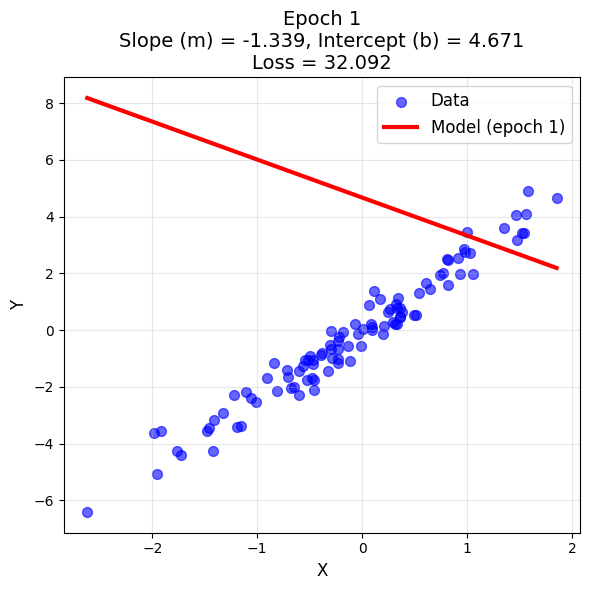

In [19]:
# First training step
y_pred = model(X_tensor)
loss = criterion(y_pred, y_tensor)

# Backward pass and optimization
optimizer.zero_grad()
loss.backward()
optimizer.step()

w0_hist.append(model.linear.bias.item())
w1_hist.append(model.linear.weight.item())
rmse_hist.append(np.mean((y_true - model.linear.bias.item() + model.linear.weight.item() * X) ** 2))  # MSE for display)

plot_single_epoch(X, y_true, 1, 
                  model.linear.weight.item(), 
                  model.linear.bias.item(), 
                  loss.item())

Look at the dramatic improvement after just **one iteration**:

- **Slope (m)**: -2.234 → 1.031 (now positive, matching the data trend!)
- **Intercept (b)**: 10.959 → 10.756 (slight adjustment)
- **Loss**: 872.666 → 172.428

The algorithm immediately figured out that the slope should be **positive** instead of negative. The line now goes in the right direction and fits much better! Let's continue!

Now let's **fast-forward** to see what happens after **200 iterations** of training...

Epoch 5: Loss = 14.910, Weight = -0.039, Bias = 2.865, RMSE = 3.841
Epoch 10: Loss = 1.688, Weight = 1.557, Bias = 0.833, RMSE = 2.804
Epoch 50: Loss = 0.221, Weight = 2.428, Bias = 0.004, RMSE = 3.138
Epoch 200: Loss = 0.221, Weight = 2.428, Bias = 0.004, RMSE = 3.139


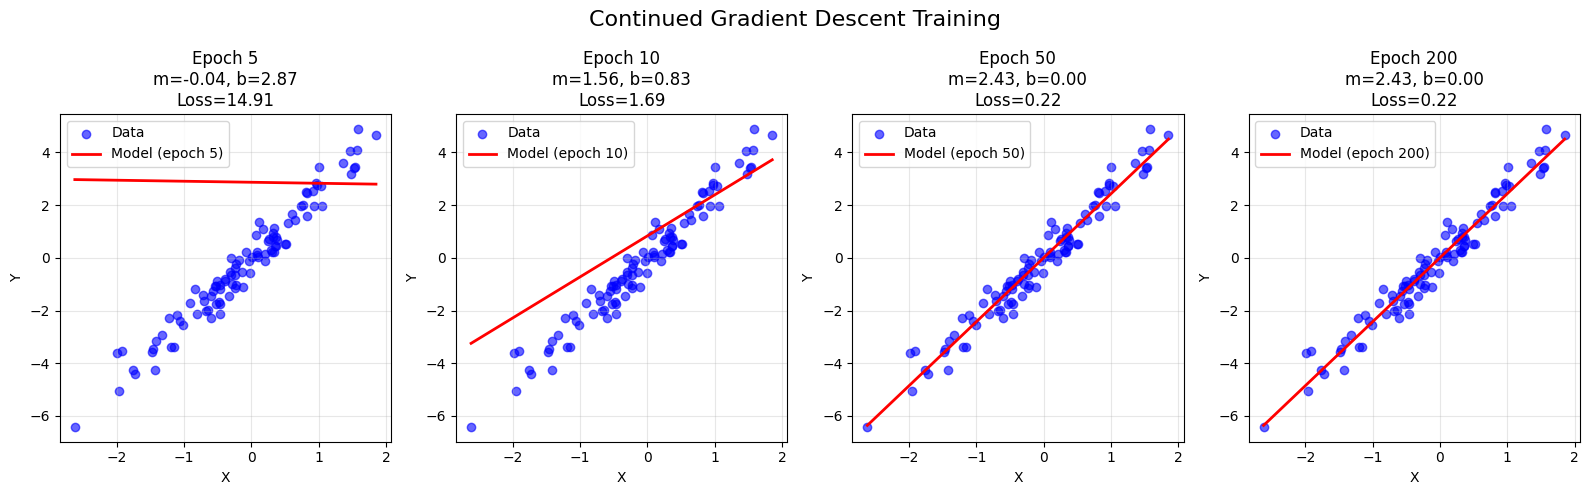

In [20]:
# Continue training and capture specific epochs
epochs_to_plot = [5, 10, 50, 200]
epoch_params = []

# Modified training loop to collect data directly in the format needed for RMSE plot
for epoch in range(3, 201):  # Continue from epoch 4
    # Forward pass
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    
    # Get current parameters
    current_weight = model.linear.weight.item()
    current_bias = model.linear.bias.item()
    current_loss = loss.item()
    
    # Calculate RMSE directly
    y_pred_numpy = current_bias + current_weight * X  # w0 + w1 * X
    current_rmse = np.sqrt(np.mean((y_true - y_pred_numpy) ** 2))
    
    # Store data in format needed for RMSE plot
    w0_hist.append(current_bias)    # intercept
    w1_hist.append(current_weight)  # slope
    rmse_hist.append(current_rmse)  # RMSE
    
    # Also store specific epochs for progression plot
    if epoch in epochs_to_plot:
        epoch_params.append((epoch, current_weight, current_bias, current_loss))
        print(f"Epoch {epoch}: Loss = {current_loss:.3f}, Weight = {current_weight:.3f}, Bias = {current_bias:.3f}, RMSE = {current_rmse:.3f}")
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the progression
plot_multiple_epochs(X, y_true, epoch_params)

Amazing! Look at how quickly gradient descent converged:

- **Epoch 10**: Already a good fit! (m=2.47, b=9.27, Loss=72.93)
- **Epoch 50**: Getting closer (m=2.47, b=4.56, Loss=15.15) 
- **Epoch 200**: Final convergence (m=2.47, b=0.96, Loss=0.86)

Notice how the **slope (m)** converged quickly to 2.47 and stayed there, while the **intercept (b)** took longer to reach its optimal value around 1.0. The loss dropped dramatically from 72.93 to 0.86!

This shows gradient descent's typical behavior - it makes rapid progress initially, then fine-tunes more slowly as it approaches the optimum.

## Visualizing the Journey: Loss Landscape

Now let's see the **big picture**! We can visualize this entire journey on the **loss landscape** - a 3D surface showing how the loss changes for different parameter values.

Closed-form Optimum: w0 = 0.004, w1 = 2.428
RMSE of Closed-form Optimum: 0.470


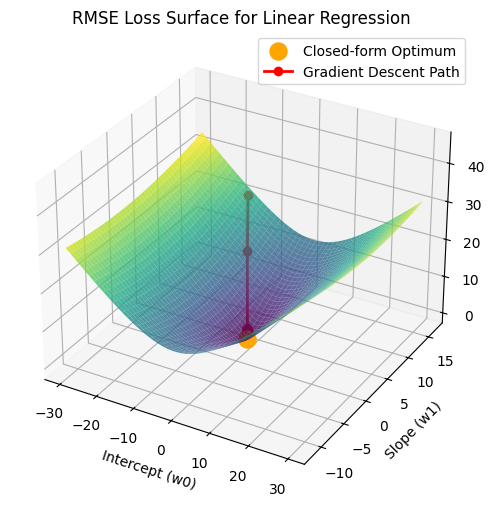

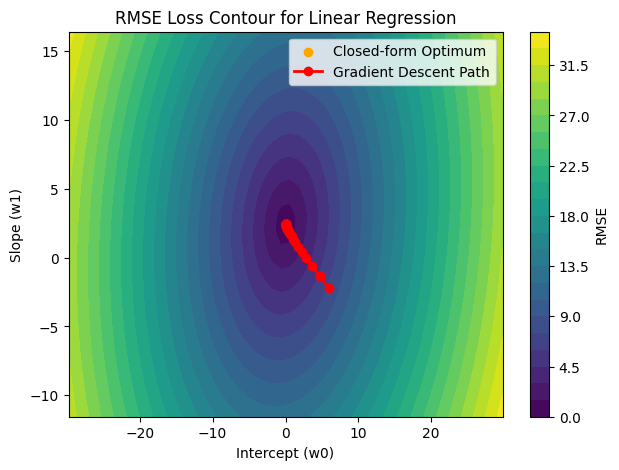

In [21]:
# TODO: Improve plots here (are a bit annoying to fix therefore we do it later)
w0_history_ds, w1_history_ds, rmse_history_ds = downsample_history((_, _, w0_hist, w1_hist, rmse_hist), k=1)

# Get the actual parameter ranges from trajectory
w0_min, w0_max = min(w0_hist), max(w0_hist)
w1_min, w1_max = min(w1_hist), max(w1_hist)

# Add padding to make the trajectory clearly visible
w0_padding = (w0_max - w0_min) * 5  # 50% padding
w1_padding = (w1_max - w1_min) * 3  # 50% padding

# Ensure minimum range for nice visualization
min_range = 0.5
w0_range_offset = max(w0_padding, min_range)
w1_range_offset = max(w1_padding, min_range)

# Use dynamic ranges
plot_rmse_loss_surface_with_arrow(X, y_true, (w0_history_ds, w1_history_ds, rmse_history_ds), 
                                 w0_range_offset=w0_range_offset,  
                                 w1_range_offset=w1_range_offset, 
                                 grid_points=50)

#plot_rmse_loss_surface_with_arrow(X, y_true, w0_history_ds, w1_history_ds, rmse_history_ds)#, w0_range_offset=1, w1_range_offset=3, grid_points=100)

Here we see our gradient descent path on the loss landscape! The red line shows the route from initial random parameters to the optimal solution (gold star).

Notice the **diagonal contours** and how the algorithm efficiently follows the steepest descent path downhill.

## From Simple Lines to Neural Networks: Backpropagation

This linear regression example perfectly illustrates gradient descent fundamentals, but the real power comes with **complex models** like neural networks where:

- There's **no closed-form solution** (unlike our linear regression)
- We have **millions or billions** of parameters to optimize
- The loss landscape is **highly non-linear** and complex

For neural networks, we use **backpropagation** - which is just gradient descent applied layer by layer through the network. Let's see how the same principles scale up.

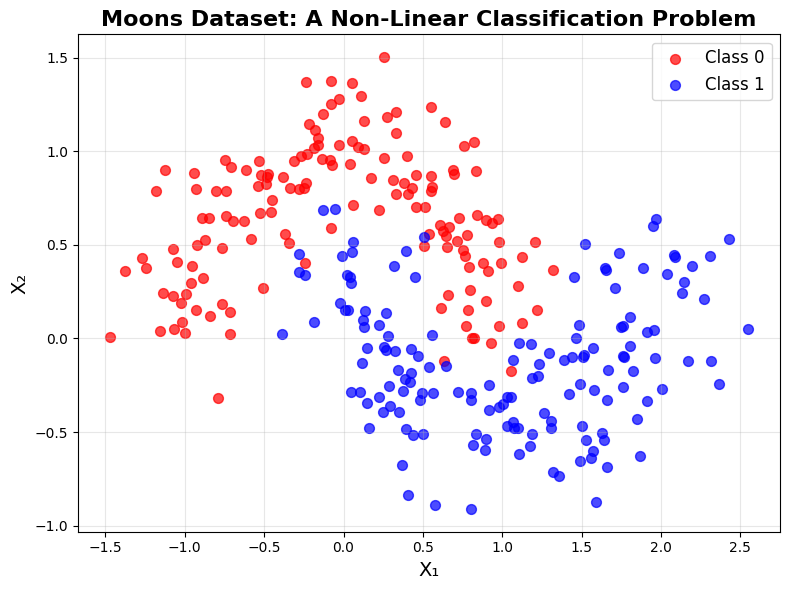

Dataset shape: (300, 2)
Class distribution: [150 150]


In [22]:
X_moons, y_moons = generate_moons_data(n_samples=300, noise=0.2, random_state=42, plot=True)

Let's use a **moons dataset** - two interleaving half-circles that create a classic non-linear classification challenge.

No straight line can separate these crescent shapes! We need a **curved decision boundary** that can wrap around the moons. Now we train a neural network to learn the boundary that perfectly separates the red and blue crescents.

Let's start with defining the MLP.

We'll create a simple **3-layer neural network**:
- **Input layer**: 2 neurons (for X₁, X₂ coordinates)
- **Hidden layers**: 20 neurons each with ReLU activation
- **Output layer**: 1 neuron with sigmoid activation (probability of Class 1)

In [23]:
model = SimpleMLP(input_size=2, hidden_size=20, output_size=2, num_layers=2)

Now we train the network and visualize how the **decision boundary evolves**:

- **Loss function**: Binary Cross-Entropy (measures classification error)
- **Optimizer**: SGD (Stochastic Gradient Descent)
- **Learning rate**: 0.5
- **Batch size**: 32 samples per update

### Mini-Batches
Instead of using all 300 samples at once, we use **batches of 32 samples**. We compute gradients on each batch and update weights. This is faster, uses less memory, and provides more stable learning than updating after every single sample.

Let's see how the decision boundary starts random and gradually learns to separate the moons.

In [24]:
# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_moons)
y_tensor = torch.FloatTensor(y_moons).unsqueeze(1)

In [25]:
# Create DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
# Load the model
model = SimpleMLP(input_size=2, hidden_size=20, output_size=1, num_layers=2)

In [27]:
# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [28]:
# Storage for results
epochs_to_show = [1, 10, 100, 1000]
total_epochs = max(epochs_to_show)
losses = []
snapshots = {}

print("Training Neural Network with Mini-Batch SGD...")
print("=" * 50)

# Training loop
for epoch in range(total_epochs + 1):
    epoch_loss = 0.0
    num_batches = 0
    
    # Process all batches in this epoch
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        if epoch > 0:  # Skip optimization for epoch 0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Average loss for this epoch
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    # Save snapshots at specific epochs
    if epoch in epochs_to_show:
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
        # Save a deep copy of the model state
        snapshots[epoch] = {
            'weights': {name: param.data.clone() for name, param in model.named_parameters()},
            'loss': avg_loss
        }

print("Training completed!")

Training Neural Network with Mini-Batch SGD...
Epoch 1: Loss = 0.6452
Epoch 10: Loss = 0.2466
Epoch 100: Loss = 0.1019
Epoch 1000: Loss = 0.0352
Training completed!


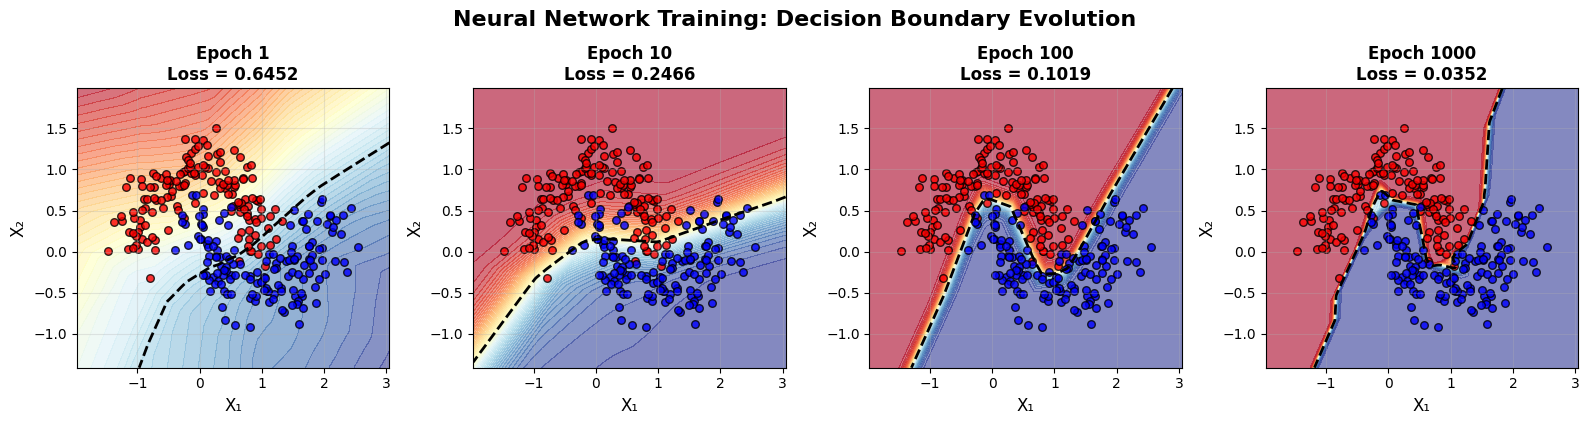

In [29]:
# Usage
plot_decision_boundary_evolution(model, snapshots, epochs_to_show, X_moons, y_moons)

The neural network learns to separate the moons through pure gradient descent:

The decision boundary transforms from a rough line into a smooth curve that perfectly wraps around each moon. Now let's plot how the loss decreased throughout training.

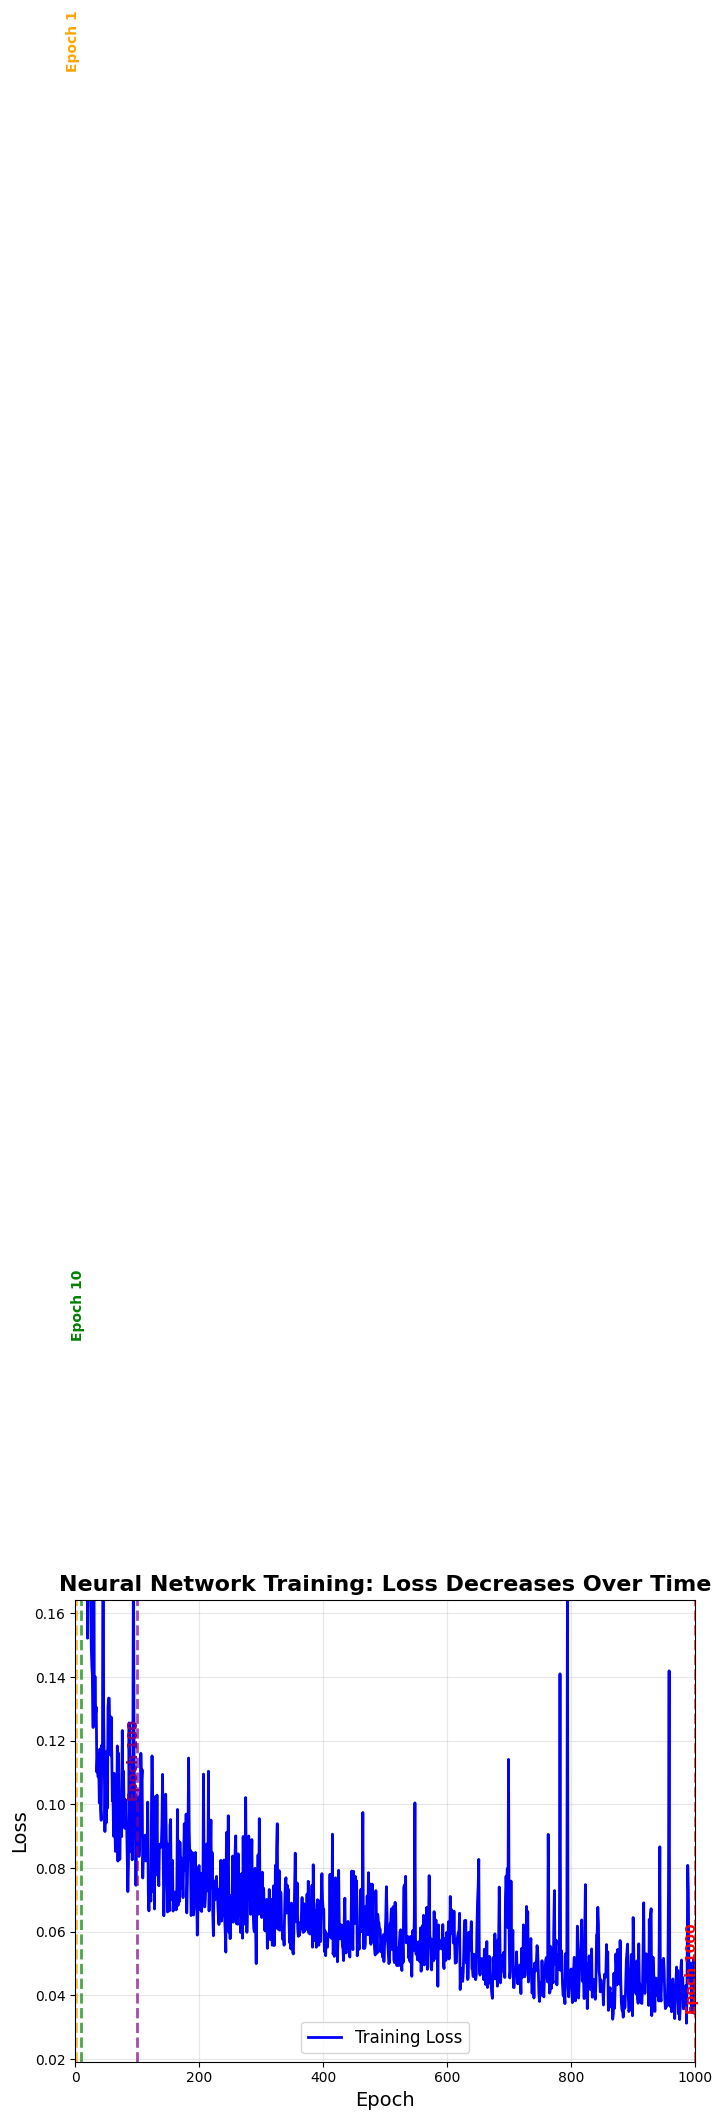

Initial loss: 0.6895
Final loss: 0.0352
Loss reduction: 94.9%


In [30]:
# Plot the training loss
plot_training_loss(losses, epochs_to_show=epochs_to_show)

This loss curve tells the complete story of gradient descent in action:

- **Rapid initial drop**: Loss plummets from 0.71 to ~0.25 in just 100 epochs
- **Steady refinement**: Gradual improvement as the boundary gets fine-tuned
- **Convergence**: Loss stabilizes around 0.06 - the network has learned!

The steep initial descent followed by gradual refinement is the signature of successful neural network training.

---
<br><br>
# Hyperparameter Tuning: The Art of Neural Networks

In neural networks, there are **tons of parameters** that can be flexibly chosen to optimize performance:

structure bullet points based on model/architecture structure

- **Learning rate**: How big steps to take during gradient descent
- **Number of layers**: Network depth (deeper = more complex patterns)
- **Layer dimensions**: How many neurons per layer
- **Number of iterations**: How long to train
- **Batch size**
- **And many more** once we introduce advanced techniques (optimizers, regularization, etc.)

Let's experiment with a different learning rates to see how they affect our moon classification.

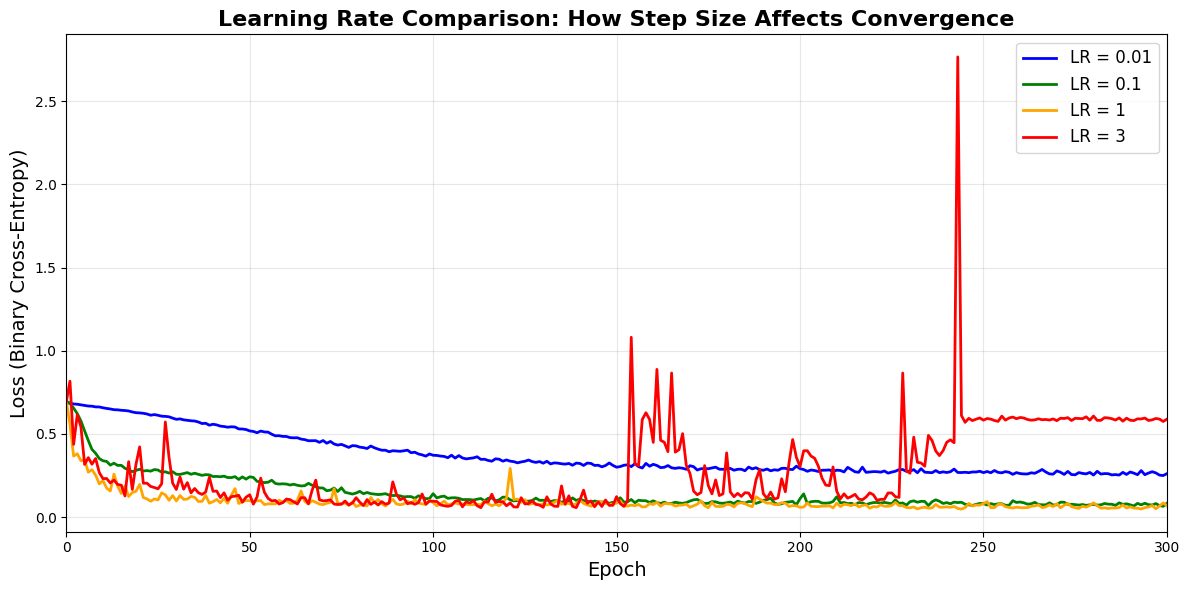

In [31]:
# Compare different learning rates
learning_rates = [0.01, 0.1, 1, 3]
total_epochs = 300

all_losses = compare_learning_rates(dataloader, learning_rates, total_epochs)

Now after training 4 models, let's plot the losses and compare!

## Learning Rate Analysis: Finding the Sweet Spot

- **LR = 0.01 (Blue)**: Very slow learner - was still improving after 500 epochs, showing steady but glacial progress.
- **LR = 0.1 (Green)**: Learns faster and reaches a stable loss quite quickly - a good balance of speed and stability.
- **LR = 0.5 (Orange)**: Learned even faster but started to show signs of instability later on with occasional spikes.
- **LR = 1.8 (Red)**: Learned even faster initially but was much more unstable throughout training with frequent oscillations.

**The Goldilocks Principle**: Low learning rates are stable but slow, while high learning rates are fast but unstable. The art is finding the rate that's "just right" for your specific problem.

Now that we understand the fundamentals of Deep Learning, we're ready to explore more sophisticated architectures. Next, we'll dive into **Convolutional Neural Networks (CNNs)** - the powerhouse behind computer vision breakthroughs.

---
<br><br>
# Convolutional Neural Networks: Processing Images

**Convolutional Neural Networks (CNNs)** are specialized neural networks designed to process **grid-like data** - especially images. While regular neural networks treat each pixel independently, CNNs understand that **nearby pixels are related** and should be processed together.

Instead of looking at the entire image at once, CNNs use **small filters** that scan across the image, detecting local features like:
- **Edges and lines** (low-level features)
- **Shapes and textures** (mid-level features)  
- **Complex patterns** (high-level features)

This hierarchical approach builds up understanding from simple to complex features.

This makes them perfect for applications like medical imaging, where detecting patterns in X-rays or MRI scans can assist in diagnosis.

Let's start with a simple example using **MNIST digits** to understand CNN fundamentals, then see how these same principles scale to real-world image recognition tasks.

## Quick Recap MNIST

The **MNIST dataset** is a classic benchmark in machine learning, consisting of 70,000 grayscale images of handwritten digits (0–9), each 28×28 pixels in size. Its simplicity and visual clarity make it ideal for understanding data science techniques before applying them to more complex, real-world datasets.


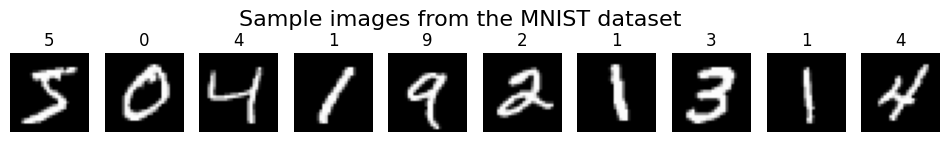

In [32]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
plot_mnist(mnist)

Now let's prepare the data first, such that we can use it afterwards for training the CNN.

In [33]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_mnist(mnist, subset_size=10000)

Using subset: 10,000 total samples
Training set: 8,000 images
Test set: 2,000 images
Reduction: 14.3% of original dataset


Now that we got the data prepared, let's define a simple CNN!

## Understanding the CNN Architecture

### Convolutional Layers: The Heart of CNNs

**Convolutional layers** are what make CNNs special. Instead of connecting every pixel to every neuron, they use small **filters** (or kernels) that slide across the image:

- **In/Out Channels**: Think of channels as "color layers." MNIST has 1 channel (grayscale), while RGB images have 3. Our first layer takes 1 input channel and produces 32 output channels - essentially creating 32 different "feature maps" that detect different patterns.

- **Kernel Size**: The 3×3 kernel size means each filter looks at a 3×3 pixel neighborhood at a time. This is small enough to detect local features like edges and corners.

- **Padding**: Adding padding=1 means we add a border of zeros around the image. This ensures that pixels at the edges get processed just as much as pixels in the center, keeping our output the same size as the input.

### Pooling: Reducing Complexity

**Max pooling** takes the maximum value from each 2×2 region, effectively reducing the image size by half (28×28 → 14×14 → 7×7). This:
- Reduces computational cost
- Makes the network more robust to small shifts in the image
- Helps focus on the most important features

### The Feature Hierarchy

Our CNN builds understanding in layers:
1. **First conv layer**: Detects basic edges and lines
2. **Second conv layer**: Combines edges into shapes and textures  
3. **Fully connected layers**: Combines all features to classify the digit (10 Outcome classes for a probability for each digit)

<img src="imgs/cnn.png" alt="Convolutional Neural Network" width="800"/>

Let's explore the training and test performance of our model during training!

In [34]:
# Initialize the CNN model, the parameters are already set for our MNIST task
cnn_model = SimpleCNN()

In [35]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
cnn_model = cnn_model.to(device)

Using device: cpu


In [36]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:
# Training setup
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)

In [38]:
# Training parameters
num_epochs = 20
train_losses = []
test_losses = []

print("Training CNN with Stochastic Gradient Descent...")
print("=" * 55)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    cnn_model.train()
    train_loss = 0.0
    train_batches = 0
    
    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = cnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    # Evaluation phase
    cnn_model.eval()
    test_loss = 0.0
    test_batches = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            # Move data to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = cnn_model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            test_batches += 1
    
    # Calculate average losses
    avg_train_loss = train_loss / train_batches
    avg_test_loss = test_loss / test_batches
    
    # Record all losses
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    # Print progress every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

print("\nTraining completed!")

Training CNN with Stochastic Gradient Descent...
Epoch  1/20: Train Loss = 2.3021, Test Loss = 2.2978
Epoch  6/20: Train Loss = 1.9277, Test Loss = 1.5791
Epoch 11/20: Train Loss = 0.4055, Test Loss = 0.3975
Epoch 16/20: Train Loss = 0.3018, Test Loss = 0.3045
Epoch 20/20: Train Loss = 0.2387, Test Loss = 0.2529

Training completed!


We finished training our model, let's visualize how the loss behaved!

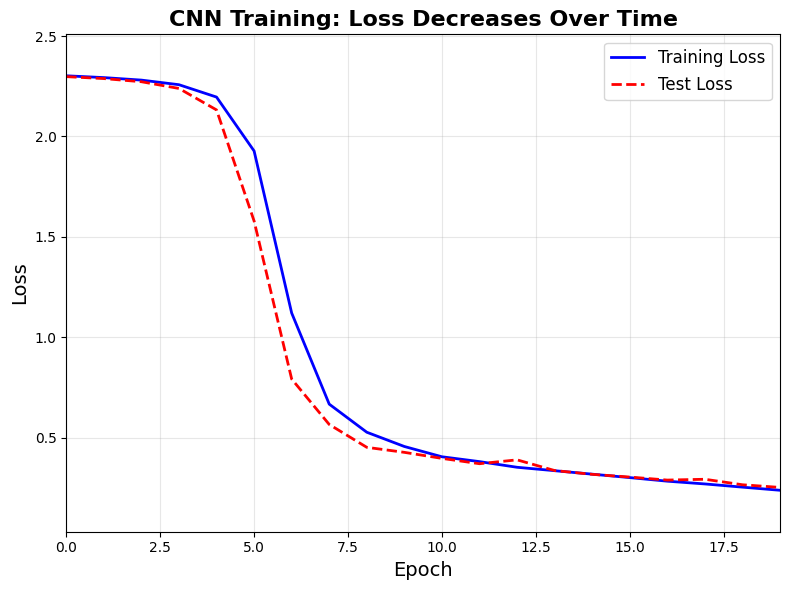

Initial loss: 2.3021
Final loss: 0.2387
Loss reduction: 89.6%


In [39]:
plot_training_loss(train_losses, test_losses, title='CNN Training: Loss Decreases Over Time')

Looking at our loss curves, we can see that **the CNN successfully learned to distinguish between different handwritten digits**. Both training and test losses decrease rapidly in the first few epochs, then stabilize at low values around 0.1. 

Importantly, the **test loss closely follows the training loss** throughout training, indicating that our model **generalizes well** to unseen data rather than just memorizing the training examples.

Now let's investigate some of the filters and results after pooling to get a better intuitive understanding.

In [40]:
#image, title = get_sample(X_test_tensor, y_test_tensor, label_names=mnist.target_names)

#extract_and_plot_feature_maps(cnn_model, image, title, category_name='Digit')

Looking at our feature maps, we can see exactly how the CNN processes the digit "8":

**Top Row (Conv1)**: Each filter detects different basic features like edges, curves, and lines.

**Bottom Row (Conv2, after pooling)**: The second layer starts combining these basic features into more complex patterns. The representations also become more compact through pooling.

The bright yellow/green regions show where each filter "fires" most strongly, revealing what visual patterns the network considers important for identifying this particular digit.

---

## Analyzing Intermediate Representations

Beyond individual filters, we can also analyze how the network transforms entire images through its layers. Let's examine the **vector representations** that emerge after:
1. **Flattened convolutional features** (3,136 dimensions)
2. **First linear layer** (128 dimensions) 
3. **Final linear layer** (10 dimensions)

Using MDS, we can visualize how different digits cluster in these high-dimensional spaces:

Analyzing 500 test samples
Flattened Conv Features: (500, 3136)
FC1 Layer Representations: (500, 128)
FC2 Layer Representations: (500, 128)
Output Layer: (500, 10)


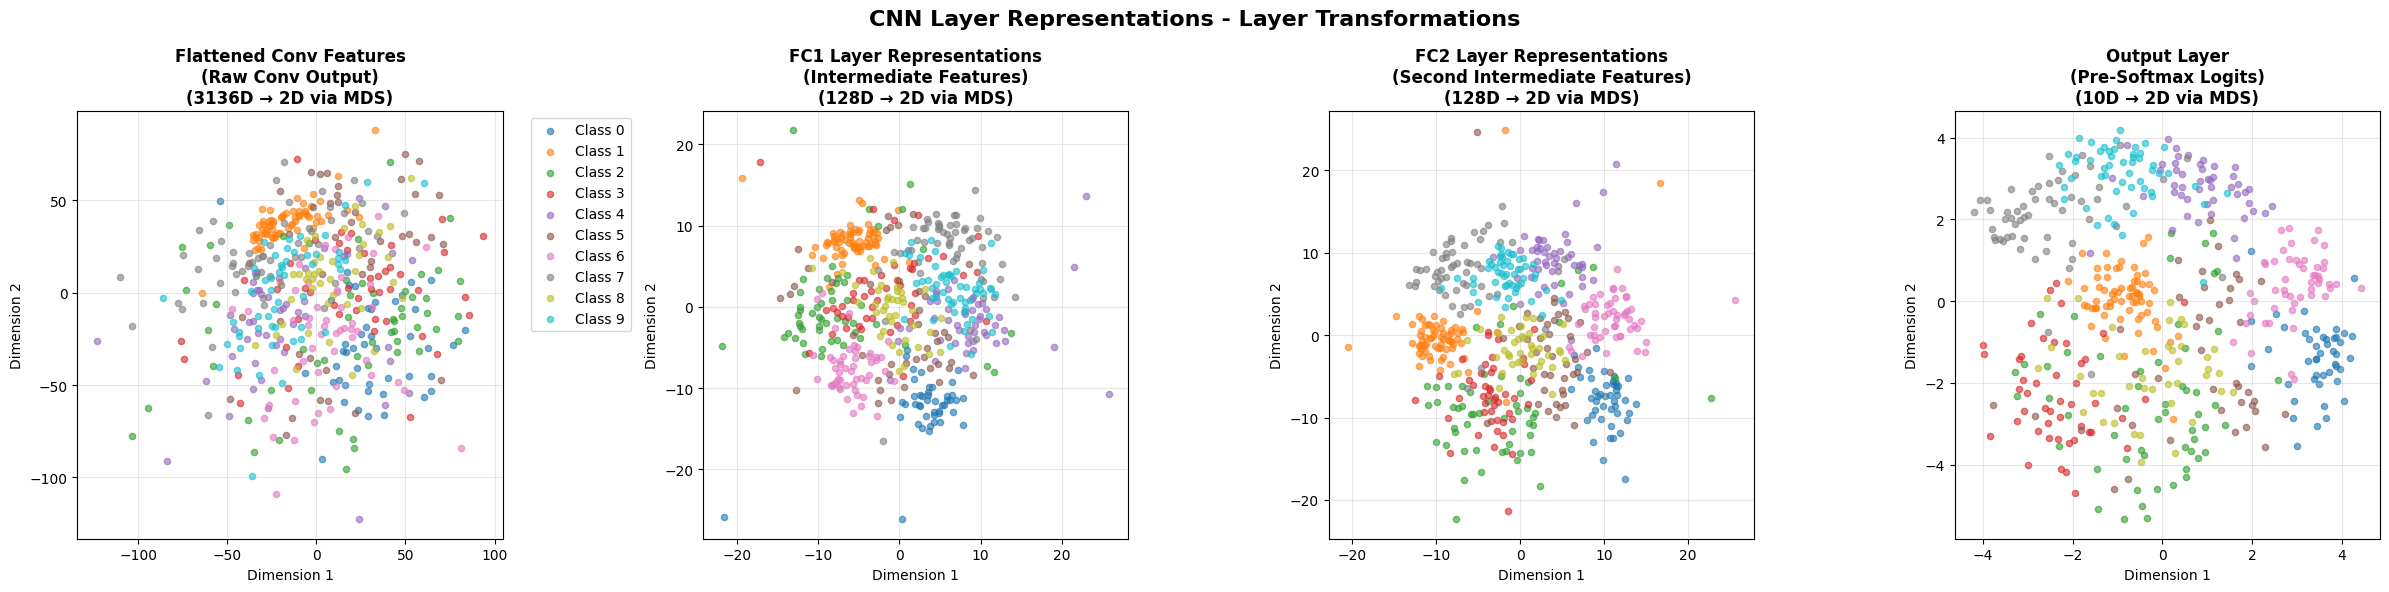

In [41]:
visualize_model_representations(cnn_model, X_test_tensor, y_test_tensor, model_type='cnn', num_samples=500)

In [42]:
# TODO: evtl add output layer to visualization
# TODO: Use the newe function, visualize_model_representations
#visualize_cnn_representations(cnn_model, X_test_tensor, y_test_tensor, num_samples=500)

This MDS visualization shows how the CNN progressively separates different digits:

**Left (Flattened Conv Features)**: After convolutional layers, we don't see clear digit clustering yet - the features are still quite mixed.

**Middle (FC1 Layer)**: After just one linear layer, the model groups digits together much more effectively with distinct clusters emerging.

**Right (FC2 Layer)**: The second layer creates even tighter, well-separated clusters in the feature space.

This demonstrates how deep networks automatically discover increasingly refined representations that make classification easier at each layer.

---
<br><br>
# Let's transfer our knowledge now to real-world datasets!

Now that we've built a solid foundation with neural networks and CNNs using the MNIST dataset, it's time to apply these powerful tools to real-world medical problems. 

We'll explore three different applications that showcase the versatility of deep learning in healthcare:

1. **Regression Task**: Predicting continuous medical outcomes using patient data
2. **Classification without Images**: Diagnosing conditions using structured clinical data  
3. **Classification with Images**: Analyzing medical imaging data using CNNs

These examples will demonstrate how the same fundamental concepts we've learned - from basic neural networks to convolutional architectures - can be adapted to solve diverse medical challenges, from predicting patient outcomes to interpreting medical scans.

Let's see deep learning in action for healthcare!

## Regression Task: Diabetes Progression Prediction

We'll start with a **regression task** using the diabetes progression dataset to demonstrate how neural networks can predict continuous medical outcomes.

### Dataset: Diabetes Progression
- **442 patients** with diabetes
- **10 physiological features**: age, sex, BMI, blood pressure, and 6 blood serum measurements
- **Target**: Quantitative measure of disease progression one year after baseline

Our goal is to build a neural network that predicts diabetes progression scores based on baseline physiological measurements, demonstrating how deep learning can capture complex relationships between metabolic factors.

Let's predict diabetes outcomes!

In [43]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Convert to pandas DataFrame for easier exploration
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='progression')

df = pd.concat([X, y], axis=1)

In [44]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          442 non-null    float64
 1   sex          442 non-null    float64
 2   bmi          442 non-null    float64
 3   bp           442 non-null    float64
 4   s1           442 non-null    float64
 5   s2           442 non-null    float64
 6   s3           442 non-null    float64
 7   s4           442 non-null    float64
 8   s5           442 non-null    float64
 9   s6           442 non-null    float64
 10  progression  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


Now that we have our diabetes dataset loaded, let's design a neural network to predict disease progression. We'll create a simple feedforward network that can learn the complex relationships between physiological measurements and diabetes outcomes.

Our network will take the 10 input features and learn to map them to a single continuous output representing disease progression.

In [46]:
model = SimpleMLP(input_size=10, hidden_size=32, output_size=1, num_layers=2)

Before we can train our neural network, we need to prepare the data by splitting it into training and testing sets, scaling the features, and converting everything to PyTorch tensors.

In [47]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_data_for_mlp(X, y)

X_train: torch.Size([353, 10]), y_train: torch.Size([353, 1])
X_test: torch.Size([89, 10]), y_test: torch.Size([89, 1])


### Training the Neural Network

Now let's train our model! We'll define all the key hyperparameters upfront so you can experiment with different values and see how they affect performance.

Great! We can see that both training and test losses decreased steadily throughout training, indicating that our model is learning effectively and generalizing well to unseen data. The convergence of both curves suggests minimal overfitting.

Let's visualize the loss evolution:

In [48]:
train_losses, test_losses, _ = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, task_type='regression')

=== DETECTED TASK TYPE: REGRESSION ===
Regression setup:
  Loss function: MSELoss()
  Target shape: torch.Size([353, 1])
  Target range: [-1.6515, 2.4665]

Epoch | Train Loss | Test Loss  | Test Acc | LR
-------------------------------------------------------
    1 |     1.0196 |    0.8894 |      N/A | 0.001000
   20 |     0.8413 |    0.7598 |      N/A | 0.001000
   40 |     0.7672 |    0.6812 |      N/A | 0.001000
   60 |     0.8881 |    0.6266 |      N/A | 0.001000
   80 |     0.6255 |    0.5865 |      N/A | 0.001000
  100 |     0.5840 |    0.5552 |      N/A | 0.001000
  120 |     0.6223 |    0.5303 |      N/A | 0.001000
  140 |     0.5731 |    0.5101 |      N/A | 0.001000
  160 |     0.5125 |    0.4934 |      N/A | 0.001000
  180 |     0.5092 |    0.4801 |      N/A | 0.001000
  200 |     0.5167 |    0.4691 |      N/A | 0.001000
Training completed!


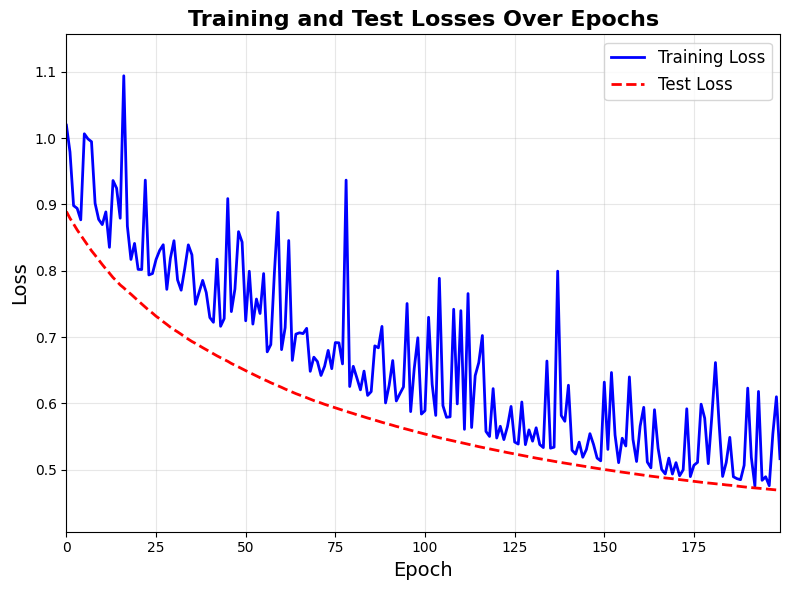

Initial loss: 1.0196
Final loss: 0.5167
Loss reduction: 49.3%


In [49]:
plot_training_loss(train_losses, test_losses, title='Training and Test Losses Over Epochs')

We observe a steady decline in both training and test losses, which is excellent! However, notice the spiky behavior in the training loss - this is characteristic of the gradient descent implementation of sklearn with batches, where each batch provides a noisy estimate of the true gradient, leading to fluctuations during training.

Now let's compare our neural network's final performance against other popular regression methods: linear regression, random forest, and gradient boosting.

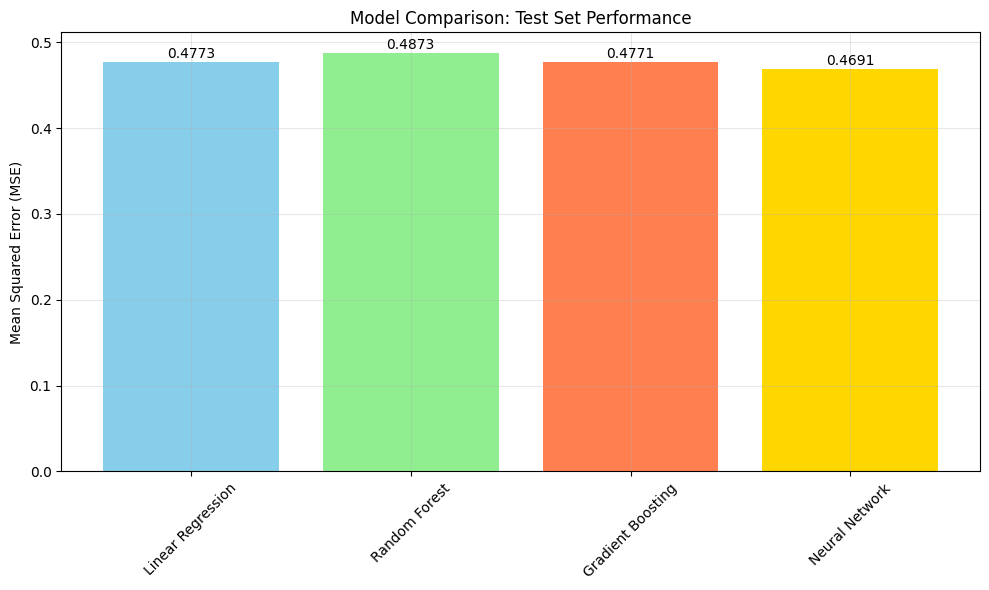

Model Performance Comparison (Test Set MSE):
---------------------------------------------
Linear Regression   : 0.4773
Random Forest       : 0.4873
Gradient Boosting   : 0.4771
Neural Network      : 0.4691


In [50]:
nn_model = model  # Reuse the trained MLP model
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

compare_regression_models(nn_model, lr_model, rf_model, gb_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

All four models perform reasonably well on this regression task, with our neural network achieving the best performance (lowest MSE of 0.4610). 

However, it's important to interpret these results cautiously:
- **Hyperparameter tuning**: We could potentially improve the other models significantly by tuning their hyperparameters (e.g., tree depth, learning rates, regularization)
- **Dataset size**: This is a relatively small dataset (~442 samples), where simpler models often perform competitively
- **Cross-validation**: We used a single train/test split to save time, but proper cross-validation would give us more robust performance estimates
- **Training time**: Neural networks require more computational resources and tuning compared to traditional ML methods

This comparison demonstrates the potential of neural networks, but in practice, always consider the trade-offs between model complexity, interpretability, and computational cost when choosing your approach!

## Binary Classification with Neural Networks: Breast Cancer Detection

Welcome back to the **Breast Cancer Wisconsin dataset**! As we've explored this dataset before, let's quickly recap: we're working with 30 features extracted from digitized images of breast mass cell nuclei (radius, texture, perimeter, area, etc.) to predict whether a tumor is **malignant** (0) or **benign** (1).

This time, we'll tackle this as a **binary classification problem** using neural networks and compare the performance against traditional machine learning approaches. Classification differs from regression in that we're predicting discrete categories rather than continuous values, which requires different loss functions and evaluation metrics.

Let's dive in!

In [51]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

df = pd.concat([X, y], axis=1)

In [52]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

We have a clean, well-balanced dataset with 569 samples and 30 features. Now let's define our neural network architecture for binary classification:

In [54]:
model = SimpleMLP(input_size=30, hidden_size=64, output_size=1, num_layers=3)

Our classification network is similar to the regression model but with a key difference: we use a **sigmoid activation** in the output layer to produce probabilities between 0 and 1 for binary classification.

Now let's prepare our data for training. For classification tasks, we'll use **stratified splitting** to maintain the same class proportions in both training and test sets:

In [55]:
# prepare the data
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_data_for_mlp(X, y, scale_target=False)

X_train: torch.Size([455, 30]), y_train: torch.Size([455, 1])
X_test: torch.Size([114, 30]), y_test: torch.Size([114, 1])


Our data is properly scaled and converted to PyTorch tensors. Now let's train our binary classifier using **Binary Cross Entropy (BCE) loss** - the standard loss function for binary classification problems:

In [56]:
train_losses, test_losses, _ = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, task_type='classification')

=== DETECTED TASK TYPE: CLASSIFICATION ===
Binary classification setup:
  Loss function: BCEWithLogitsLoss()
  Target shape: torch.Size([455, 1])
  Target values: tensor([0., 1.])

Epoch | Train Loss | Test Loss  | Test Acc | LR
-------------------------------------------------------
    1 |     0.6969 |    0.6962 |   0.3772 | 0.001000
   20 |     0.6836 |    0.6830 |   0.6842 | 0.001000
   40 |     0.6709 |    0.6699 |   0.8772 | 0.001000
   60 |     0.6573 |    0.6568 |   0.7807 | 0.001000
   80 |     0.6434 |    0.6430 |   0.6842 | 0.001000
  100 |     0.6314 |    0.6277 |   0.6842 | 0.001000
  120 |     0.6121 |    0.6099 |   0.7193 | 0.001000
  140 |     0.5873 |    0.5884 |   0.7456 | 0.001000
  160 |     0.5689 |    0.5623 |   0.7895 | 0.001000
  180 |     0.5374 |    0.5306 |   0.8333 | 0.001000
  200 |     0.5055 |    0.4924 |   0.8772 | 0.001000
Training completed!
Final test accuracy: 0.8772


The training completed successfully! Looking at the loss evolution, we can observe a classic **overfitting pattern**: the training loss continues to decrease steadily throughout all 200 epochs (from 0.6773 to 0.0335), while the test loss plateaus around epoch 100-120 and even starts to slightly increase toward the end.

This behavior indicates that our model is memorizing the training data rather than learning generalizable patterns. The gap between training and test loss widens over time, which is a clear sign of overfitting. In practice, we could use techniques like early stopping (around epoch 100) or regularization to prevent this.

Let's visualize this overfitting pattern:

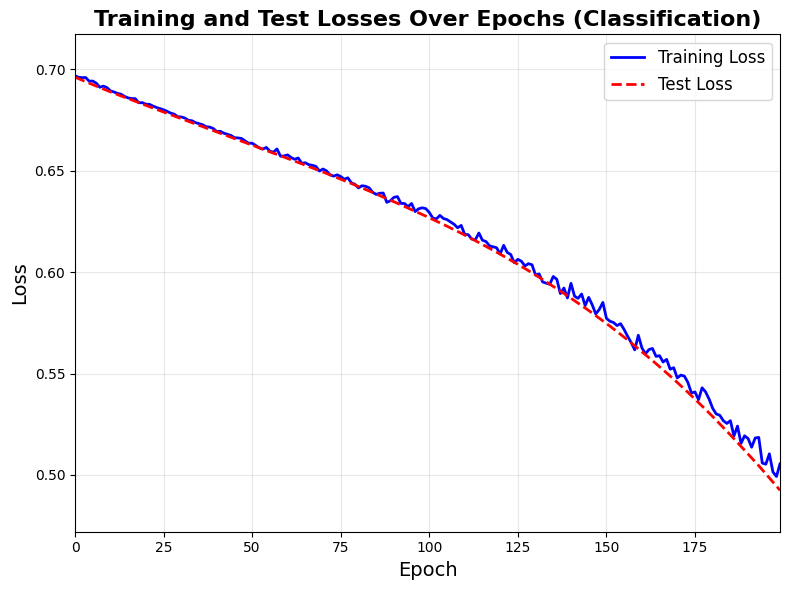

Initial loss: 0.6969
Final loss: 0.5055
Loss reduction: 27.5%


In [57]:
plot_training_loss(train_losses, test_losses, title='Training and Test Losses Over Epochs (Classification)')

The plot makes the overfitting behavior crystal clear! 

The divergence between the curves after epoch 100 shows our model is becoming too specialized to the training data. Despite this overfitting, let's see how our neural network performs compared to traditional machine learning approaches:

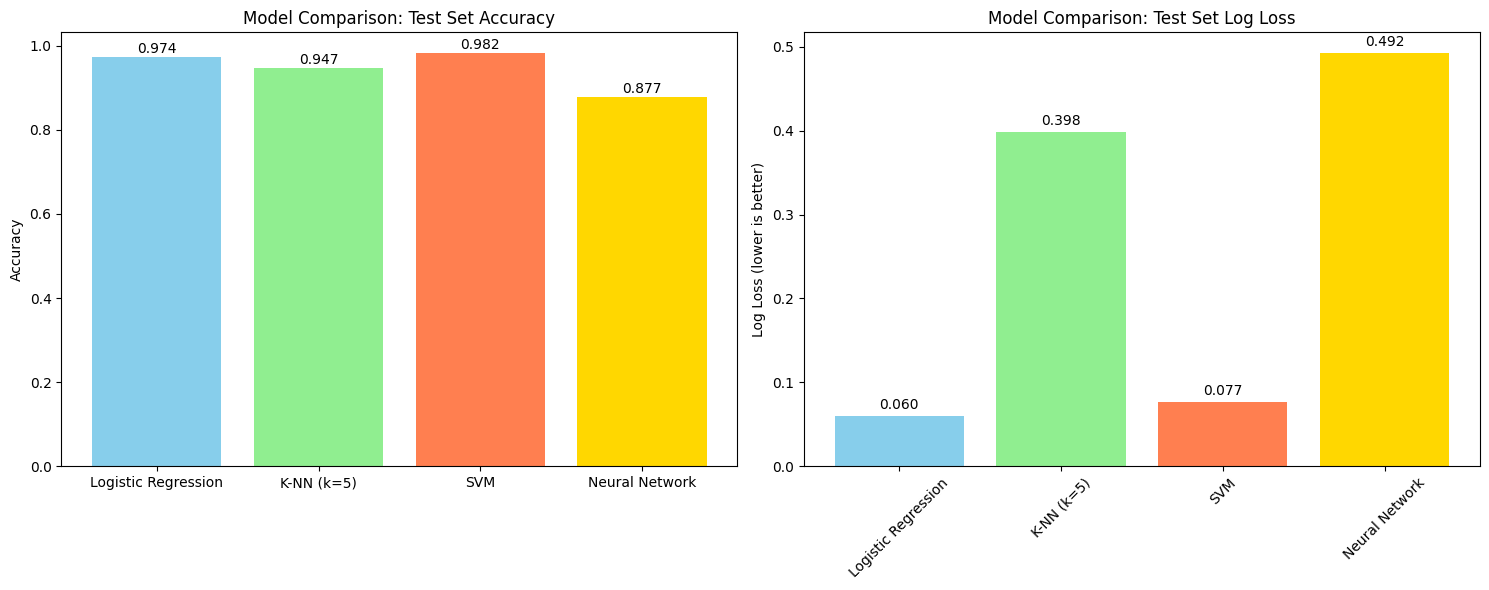

Model Performance Comparison:
------------------------------------------------------------
Method               Accuracy   Log Loss  
------------------------------------------------------------
Logistic Regression  0.974      0.060     
K-NN (k=5)           0.947      0.398     
SVM                  0.982      0.077     
Neural Network       0.877      0.492     

Best accuracy: SVM
Best log loss: Logistic Regression


In [58]:
nn_model = model  # Reuse the trained MLP model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
knn_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC(probability=True, random_state=42)

compare_classification_models(nn_model, lr_model, knn_model, svm_model, 
                             X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# TODO UPDATE

### Model Comparison: When Simple Beats Complex

- **Best**: Logistic Regression & SVM (98.2% accuracy, low log loss)
- **Worst**: Neural Network (94.7% accuracy)

1. **Simple can be superior**: Logistic regression outperforms our neural network despite being much simpler.

2. **Overfitting hurts**: The NN's overfitting behavior likely reduced its generalization performance.

3. **Dataset matters**: With 569 samples and engineered features, traditional ML methods often excel. Neural networks shine with large, complex datasets (images, text) where they can learn representations that simpler models can't capture.

Always start simple and increase complexity only when needed!

## Convolutional Neural Networks: Chest X-ray Analysis (TODO Text Adjust to new example)

Welcome to our exploration of **Convolutional Neural Networks (CNNs)** for medical image analysis! We're shifting from tabular data to images, where spatial relationships and visual patterns are crucial.

Chest X-rays are one of the most common medical imaging procedures worldwide. Radiologists analyze these images to detect various pathological conditions like pneumonia, cardiomegaly (enlarged heart), pleural effusion, and other lung abnormalities. However, manual interpretation is time-consuming and requires specialized expertise.

### ChestMNIST Dataset (TODO Now pneumonia)

We'll use the **ChestMNIST** dataset, which contains:
- **28×28 grayscale chest X-ray images**
- **14 possible pathological conditions** (multi-label classification)
- **Real medical images** with visible anatomical structures (ribs, lungs, heart)
- **Spatial patterns matter**: Pathologies appear in specific lung regions and have characteristic shapes

Unlike our previous tabular breast cancer data, these images contain **spatial information** where the position and relationship between pixels are critical. This is where CNNs truly shine - they can detect local features like lung boundaries, rib patterns, and pathological changes while preserving spatial relationships that would be lost with traditional fully connected networks.

Let's see how CNNs revolutionize medical image analysis!

Loading PneumoniaMNIST dataset...
Full dataset sizes:
Training: 4708 images
Test: 624 images

Using subset of 800 training images
Test set: 200 images


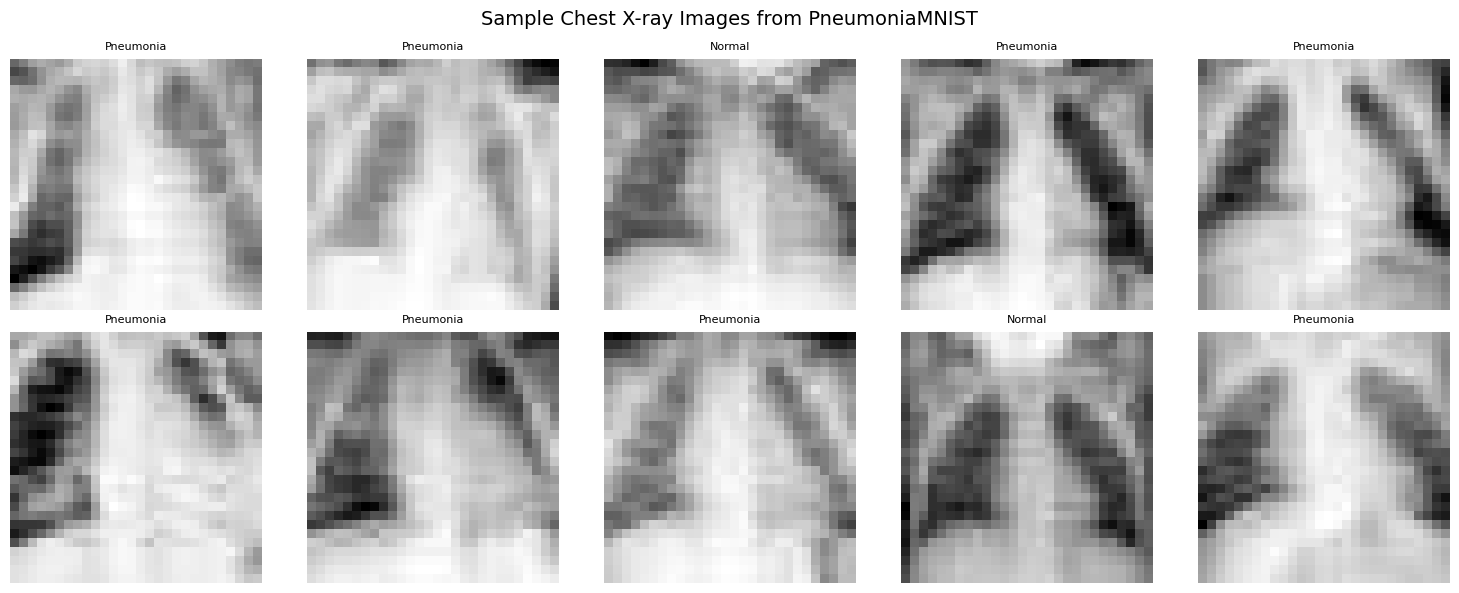

In [59]:
X_train, y_train, X_test, y_test, label_names = loadPneumoniaMNIST()

The data loading works great. Now let's define our **Convolutional Neural Network (CNN)** for chest X-ray analysis.

For medical image analysis, we'll build a CNN that can capture spatial patterns and anatomical features:

In [60]:
# Define the CNN
input_channels = 1
output_size = len(torch.unique(y_train))
hidden_size = 32
num_layers = 2

pneumonia_model = SimpleCNN(input_channels=input_channels, output_size=output_size, num_fc_layers=num_layers, fc_hidden_size=hidden_size)

In [61]:
# Training configuration
batch_size = 16
learning_rate = 0.001

train_loss, test_loss, _ = train_model(pneumonia_model, X_train, y_train, X_test, y_test, learning_rate=learning_rate, batch_size=batch_size, task_type='multiclass')

=== DETECTED TASK TYPE: MULTICLASS ===
Multi-class classification setup:
  Loss function: CrossEntropyLoss()
  Number of classes: 2
  Target shape: torch.Size([800, 1])

Epoch | Train Loss | Test Loss  | Test Acc | LR
-------------------------------------------------------
    1 |     0.7745 |    0.7452 |   0.3450 | 0.001000
   20 |     0.5876 |    0.6563 |   0.6550 | 0.001000
   40 |     0.5829 |    0.6603 |   0.6550 | 0.001000
   60 |     0.5785 |    0.6566 |   0.6550 | 0.001000
   80 |     0.5728 |    0.6542 |   0.6550 | 0.001000
  100 |     0.5636 |    0.6465 |   0.6550 | 0.001000
  120 |     0.5481 |    0.6310 |   0.6550 | 0.001000
  140 |     0.5118 |    0.6011 |   0.6550 | 0.001000
  160 |     0.4519 |    0.5512 |   0.6550 | 0.001000
  180 |     0.3803 |    0.4865 |   0.7300 | 0.001000
  200 |     0.3115 |    0.4204 |   0.8050 | 0.001000
Training completed!
Final test accuracy: 0.8050


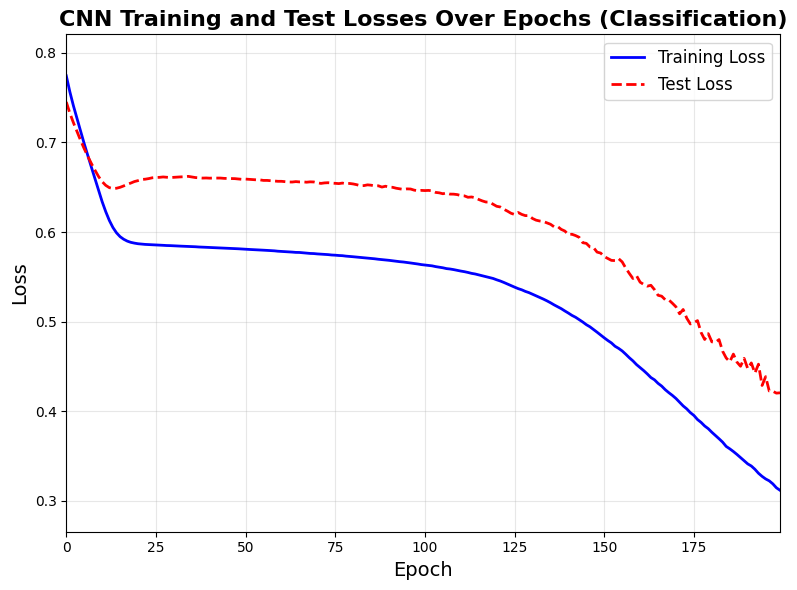

Initial loss: 0.7745
Final loss: 0.3115
Loss reduction: 59.8%


In [62]:
plot_training_loss(train_loss, test_loss, title='CNN Training and Test Losses Over Epochs (Classification)')

Accuracy: 0.8050


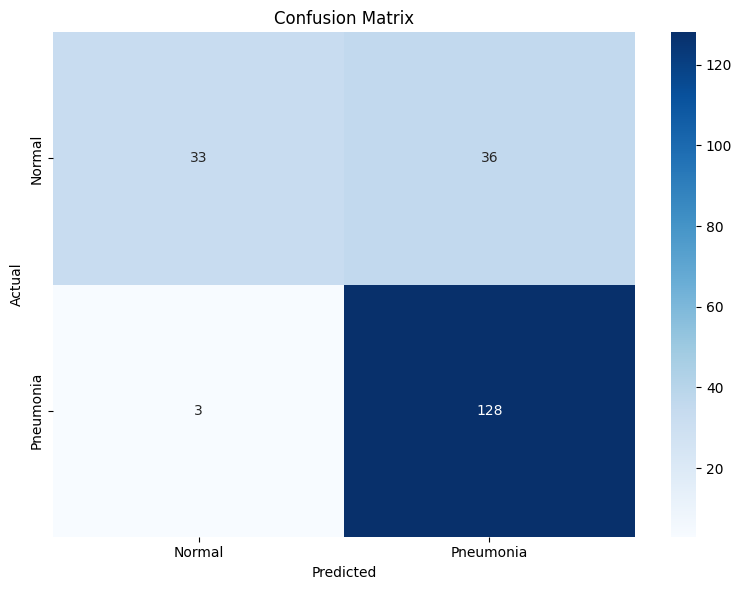

In [63]:
_ = evaluate_classification_model(pneumonia_model, (X_test, y_test), target_names=label_names, batch_size=batch_size)

In [64]:
#image, title = get_sample(X_test, y_test, label_names)

In [65]:
#extract_and_plot_feature_maps(pneumonia_model, image, title, category_name='Pneumonia Diagnosis')

Analyzing 100 test samples
Flattened Conv Features: (100, 3136)
FC1 Layer Representations: (100, 32)
FC2 Layer Representations: (100, 32)
Output Layer: (100, 2)


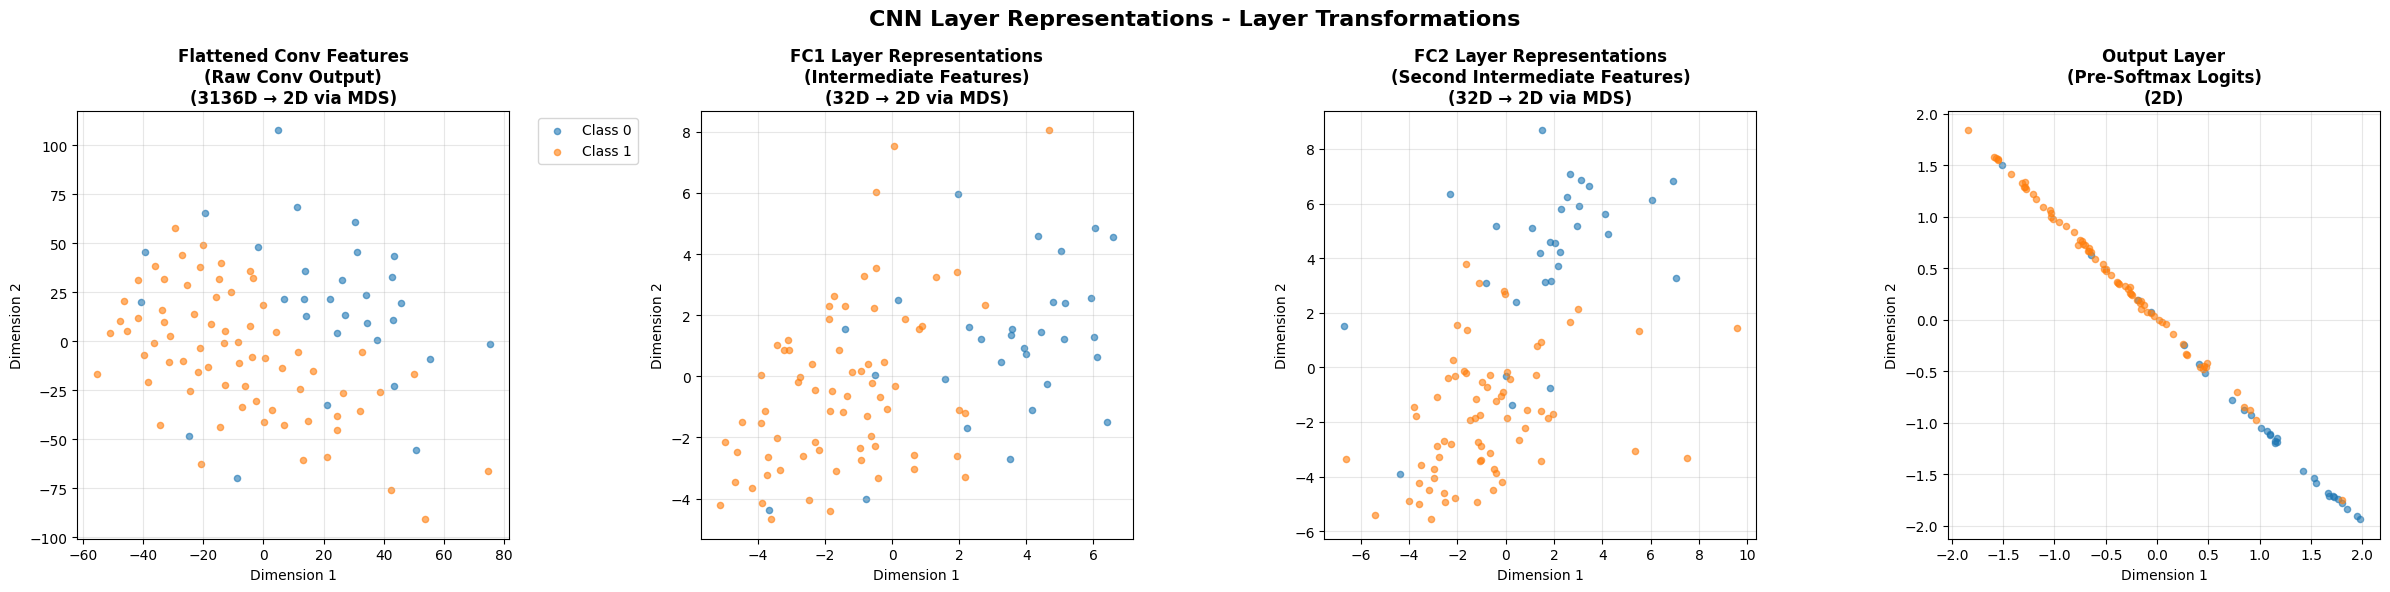

In [66]:
visualize_model_representations(pneumonia_model, X_test, y_test, model_type='cnn', num_samples=100)

# Transfer Learning: Leveraging Pre-trained Knowledge 

Our chest X-ray CNN demonstrated the power of convolutional networks, but we encountered several challenges that are common in medical AI:

**Resource Intensity:**
- Training deep CNNs requires enormous computational resources
- Medical datasets are often small (thousands vs millions of images)
- Training from scratch can take days or weeks on powerful GPUs

**Limited Performance:**
- Small medical datasets can lead to overfitting
- CNNs need large amounts of data to learn meaningful visual features
- Training from scratch often yields suboptimal results with limited data

Medical imaging datasets are inherently limited - collecting and annotating medical images requires expert radiologists, is expensive, and raises privacy concerns. Yet we need robust models for clinical deployment.

This leads us to the idea of **Transfer Learning**. Instead of learning everything from scratch, why not start with a CNN that already understands visual patterns?

1. **Start with pre-trained weights**: Use a CNN trained on millions of natural images (ImageNet)
2. **Transfer knowledge**: Low-level features (edges, textures, shapes) are universal across image domains
3. **Fine-tune for medical data**: Adapt the pre-trained model to our specific medical task
4. **Achieve better results faster**: Superior performance with less training time and data

We'll now enhance our chest X-ray classification using transfer learning - demonstrating how:
- **Visual patterns transfer**: Edge detectors and texture analyzers learned from natural images help identify anatomical structures
- **Faster convergence**: Pre-trained weights provide a much better starting point than random initialization
- **Better performance**: Transfer learning often achieves superior diagnostic accuracy with the same limited medical data
- **Clinical efficiency**: Faster training means quicker deployment of life-saving diagnostic tools

Let's compare our from-scratch CNN with a transfer learning approach and see how knowledge learned from everyday photos can dramatically improve chest X-ray analysis!

TODO: CHANGE TO mobilenet/efficientnet, because resnet is too much for my laptop

We'll use **ResNet18**, a convolutional neural network pre-trained on ImageNet - a dataset containing over 1.2 million natural images across 1,000 categories like animals, vehicles, and everyday objects. 

This model and many more are available in huggingface's `timm` library, which provides a wide range of pre-trained models for image transfer learning. (See [here](https://huggingface.co/timm) for more details)

In [67]:
efficientnet_model = timm.create_model('efficientnet_es', pretrained=True, num_classes=output_size)


# Performance is better if we don't freeze

# Freeze all layers except the classifier
# for param in efficientnet_model.parameters():
#     param.requires_grad = False

# # Only train the classifier head
# for param in efficientnet_model.classifier.parameters():
#     param.requires_grad = True

In [68]:
transform_efficientnet = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to EfficientNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

X_train_eff, y_train_eff, X_test_eff, y_test_eff, label_names = loadPneumoniaMNIST(transform=transform_efficientnet)

Loading PneumoniaMNIST dataset...
Full dataset sizes:
Training: 4708 images
Test: 624 images

Using subset of 800 training images
Test set: 200 images


Accuracy: 0.3950


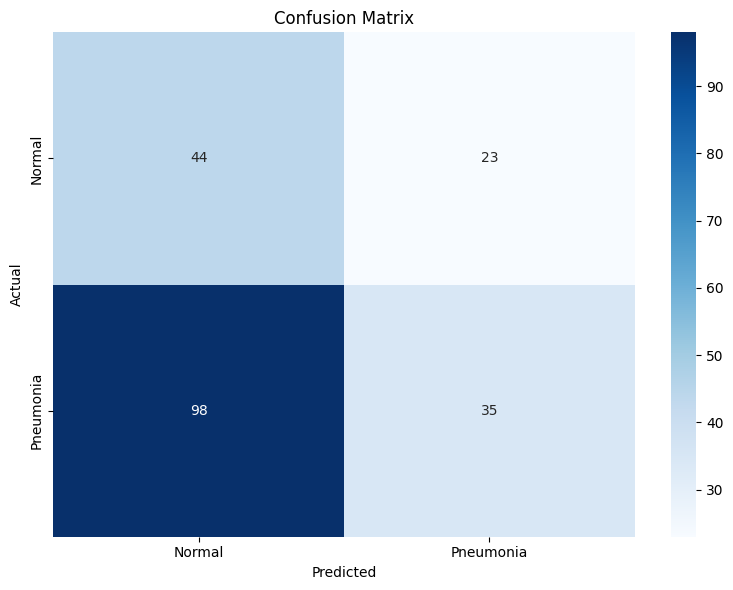

In [69]:
_ = evaluate_classification_model(efficientnet_model, (X_test_eff, y_test_eff), target_names=label_names, batch_size=batch_size)

In [70]:
learning_rate=1e-3
batch_size=16
num_epochs=10

train_loss, test_loss, _ = train_model(efficientnet_model, X_train_eff, y_train_eff, X_test_eff, y_test_eff, 
                                    learning_rate=learning_rate, batch_size=batch_size,
                                    num_epochs=num_epochs, print_every=1, task_type='multiclass')

=== DETECTED TASK TYPE: MULTICLASS ===
Multi-class classification setup:
  Loss function: CrossEntropyLoss()
  Number of classes: 2
  Target shape: torch.Size([800, 1])

Epoch | Train Loss | Test Loss  | Test Acc | LR
-------------------------------------------------------
    1 |     3.1708 |    3.0979 |   0.3600 | 0.001000
    2 |     2.8150 |    2.5951 |   0.4700 | 0.001000
    3 |     3.0030 |    2.6383 |   0.4700 | 0.001000
    4 |     2.8459 |    2.8276 |   0.4750 | 0.001000
    5 |     2.7974 |    2.4068 |   0.5000 | 0.001000
    6 |     2.7214 |    2.7972 |   0.4350 | 0.001000
    7 |     2.6382 |    2.3644 |   0.4850 | 0.001000
    8 |     2.5097 |    2.6408 |   0.4800 | 0.001000
    9 |     2.3556 |    2.5286 |   0.5100 | 0.001000
   10 |     2.3616 |    2.6006 |   0.4850 | 0.001000
Training completed!
Final test accuracy: 0.4850


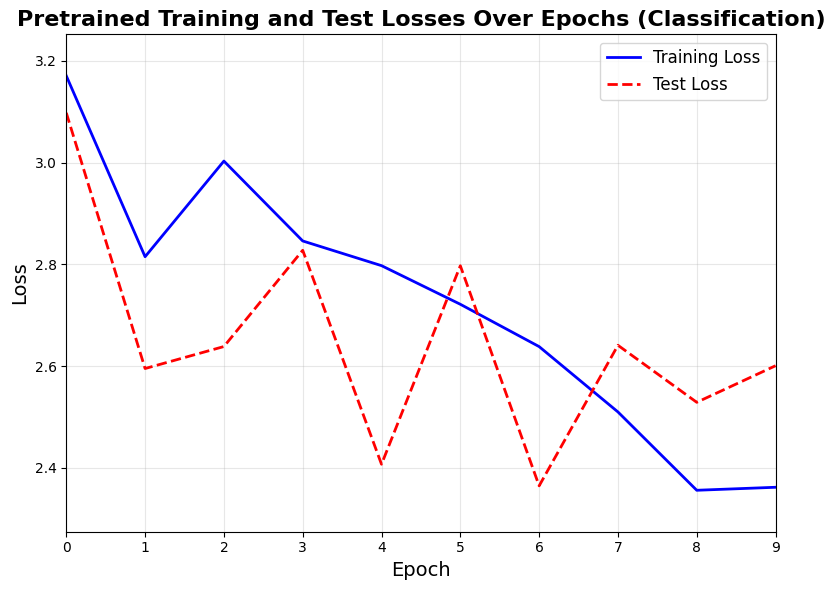

Initial loss: 3.1708
Final loss: 2.3616
Loss reduction: 25.5%


In [71]:
plot_training_loss(train_loss, test_loss, title='Pretrained Training and Test Losses Over Epochs (Classification)')

Accuracy: 0.4850


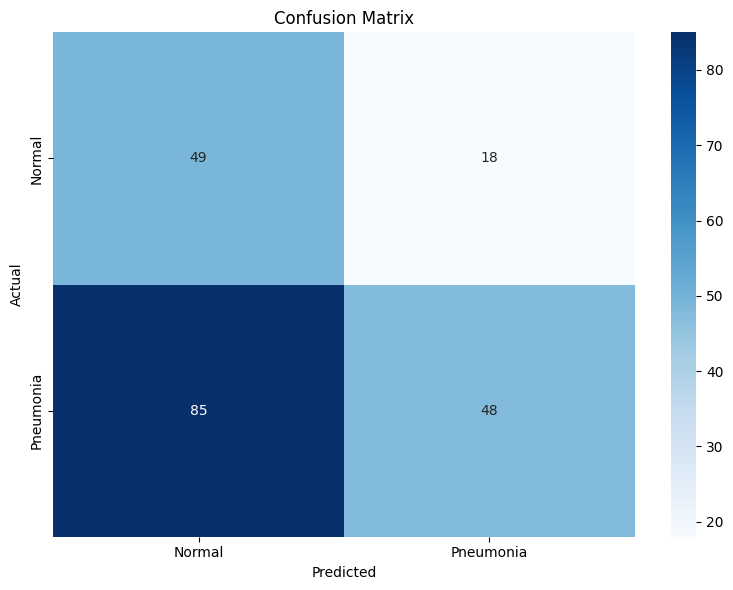

In [72]:
_ = evaluate_classification_model(efficientnet_model, (X_test_eff, y_test_eff), target_names=label_names, batch_size=batch_size)

For transfer learning, we replace the final classification layer (originally 1,000 outputs) with a new layer having 14 outputs to match our chest X-ray pathologies, while keeping all the pre-trained feature extraction layers frozen initially.

Now let's train the model on our dataset and see the improvements!

# Language Model for text analysis

We've seen how CNNs revolutionized medical imaging by learning to recognize patterns in X-rays, MRIs, and CT scans. But healthcare generates massive amounts of **text data** too: patient records, research papers, clinical notes, diagnostic reports, and patient communications. Can we apply similar AI principles to understand and generate medical language?

**Large Language Models (LLMs)** like BERT, GPT, and their variants have transformed natural language processing. These models are trained on billions of words from books, articles, and websites, learning to understand context, extract information, and even generate human-like text. Just like our ResNet18 learned visual features from millions of images, LLMs learn language patterns from enormous text datasets.

The exciting part? We can use **transfer learning** here too! A model trained on general text (Wikipedia, news articles, books) or domain-specifc text (see ClinicalBERT) already understands grammar, facts, and reasoning. We can then apply this knowledge to medical tasks like analyzing sentiments of messages, answering patient questions, analyzing clinical notes, or helping with diagnosis.

## Sentiment Analysis of Drug reviews

Let's investigate such a model in action. In the following part we will use a pretrained model to analyze the sentiment of Drug Reviews. The dataset consists of:

- 2328 positive Reviews of people who were happy with the medication they received
- 1814 negative Reviews of people who weren't

Now first we will load and explore the dataset.

In [73]:
# Load dataset
drug_reviews = pd.read_csv('drug_reviews.csv')

print(f"Dataset shape: {drug_reviews.shape}")
print(f"Label distribution:\n{drug_reviews['label'].value_counts()}")


Dataset shape: (4142, 4)
Label distribution:
label
1    2328
0    1814
Name: count, dtype: int64


In [74]:
X = drug_reviews['review']
y = drug_reviews['label']

In [75]:
# Initialize tokenizer and model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(drug_reviews['label'].unique()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:

# Split the data first
train_dataset, val_dataset = prepare_data_for_textAnalysis(X, y, tokenizer)


Training samples: 3313
Validation samples: 829
Train labels: [1451 1862]
Val labels: [363 466]
Tokenizing training data...
Tokenizing validation data...
Tokenization complete!


Accuracy: 0.4101


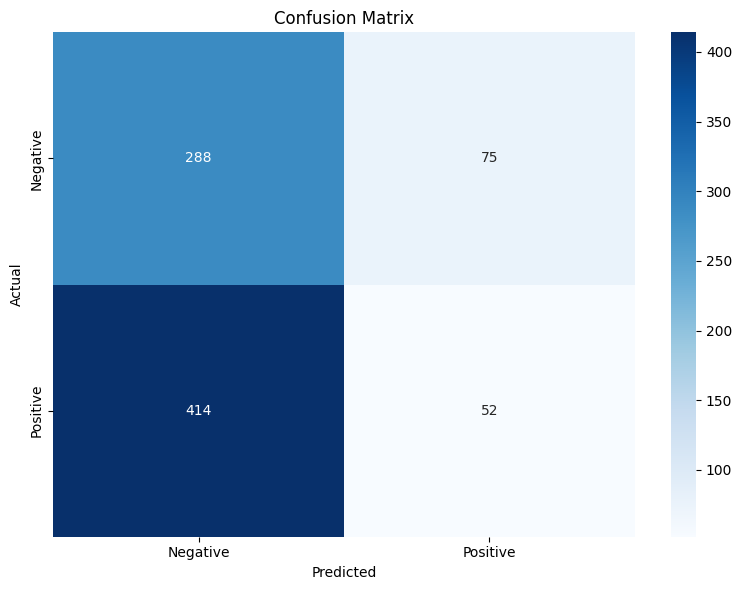

In [77]:
_ = evaluate_classification_model(model, val_dataset)

In [78]:
# Train the model

num_epochs = 2

trained_model, train_losses, val_accuracies, final_predictions, final_true_labels = train_language_model(
    model, train_dataset, val_dataset, epochs=num_epochs
)


Training batches: 208
Validation batches: 52
Using device: cpu
Epoch 1/2, Batch 50/208, Loss: 0.7128
Epoch 1/2, Batch 100/208, Loss: 0.6646
Epoch 1/2, Batch 150/208, Loss: 0.8025
Epoch 1/2, Batch 200/208, Loss: 0.7535
Epoch 1/2
  Train Loss: 0.6889
  Val Accuracy: 0.4403
--------------------------------------------------
Epoch 2/2, Batch 50/208, Loss: 0.6990
Epoch 2/2, Batch 100/208, Loss: 0.8088
Epoch 2/2, Batch 150/208, Loss: 0.7040
Epoch 2/2, Batch 200/208, Loss: 0.6789
Epoch 2/2
  Train Loss: 0.6965
  Val Accuracy: 0.4451
--------------------------------------------------


Accuracy: 0.4451


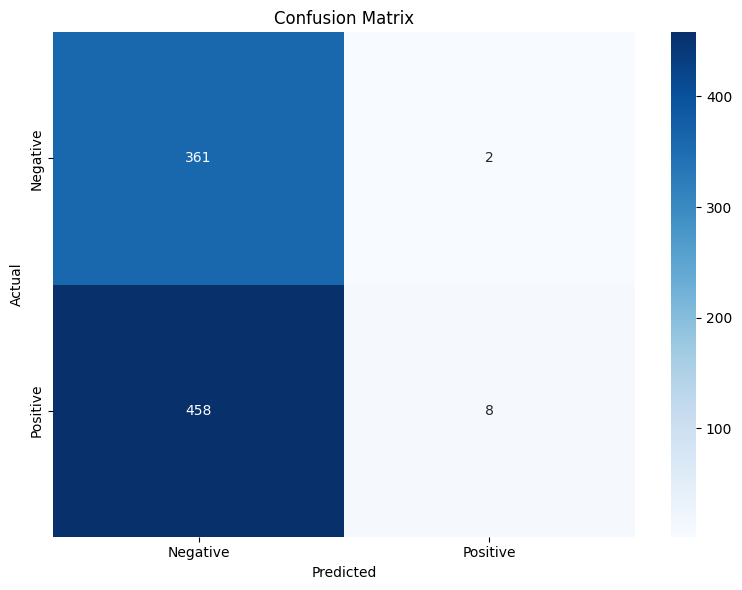

In [79]:
_ = evaluate_classification_model(trained_model, val_dataset)

---
<br><br>

# Bonus: Large Language Models for Medical Applications

We've seen how CNNs revolutionized medical imaging by learning to recognize patterns in X-rays, MRIs, and CT scans. But healthcare generates massive amounts of **text data** too: patient records, research papers, clinical notes, diagnostic reports, and patient communications. Can we apply similar AI principles to understand and generate medical language?

**Large Language Models (LLMs)** like BERT, GPT, and their variants have transformed natural language processing. These models are trained on billions of words from books, articles, and websites, learning to understand context, extract information, and even generate human-like text. Just like our ResNet18 learned visual features from millions of images, LLMs learn language patterns from enormous text datasets.

The exciting part? We can use **transfer learning** here too! A model trained on general text (Wikipedia, news articles, books) already understands grammar, facts, and reasoning. We can then apply this knowledge to medical tasks like answering patient questions, analyzing clinical notes, or helping with diagnosis - often without any additional training required.

First, let's define our **medical question-answering model**. We'll use a pre-trained model to answer questions based on a given medical context.

In [80]:
# Load a pre-trained Question Answering model
qa_model = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad",
    device=device
)

Device set to use cpu


Now let's create some context for our model, in our case we want it to answer Questions about Pneumonia. 

In [81]:
# Create a medical knowledge base for our Q&A system
medical_knowledge = """
Pneumonia is an infection that inflames air sacs in one or both lungs. The air sacs may fill with fluid or pus, 
causing cough with phlegm, fever, chills, and difficulty breathing. Pneumonia can range in seriousness from mild 
to life-threatening. It is most serious for infants and young children, people older than age 65, and people with 
health problems or weakened immune systems.

Common symptoms include: chest pain when breathing or coughing, confusion or changes in mental awareness (in adults 
age 65 and older), cough which may produce phlegm, fatigue, fever sweating and shaking chills, lower than normal 
body temperature (in adults older than age 65 and people with weak immune systems), nausea vomiting or diarrhea, 
and shortness of breath.

Treatment depends on the type and severity of pneumonia. Bacterial pneumonia is typically treated with antibiotics. 
Viral pneumonia may be treated with antiviral medications. Rest, fluids, and over-the-counter pain relievers may 
help manage symptoms. Severe cases may require hospitalization.
"""

Let's see how well our model can answer some simple questions given our medical context.

In [82]:

# Test our medical Q&A system
questions = [
    "What is pneumonia?",
    "What are the symptoms of pneumonia?",
    "How is pneumonia treated?",
    "Who is most at risk for serious pneumonia?"
]

print("🏥 Medical Q&A Assistant Demo:")
print("=" * 50)

for i, question in enumerate(questions, 1):
    result = qa_model(question=question, context=medical_knowledge)
    
    print(f"Q{i}: {question}")
    print(f"A{i}: {result['answer']}")
    print(f"Confidence: {result['score']:.3f}")
    print("-" * 30)

🏥 Medical Q&A Assistant Demo:
Q1: What is pneumonia?
A1: an infection that inflames air sacs in one or both lungs
Confidence: 0.722
------------------------------
Q2: What are the symptoms of pneumonia?
A2: chest pain when breathing or coughing, confusion or changes in mental awareness
Confidence: 0.381
------------------------------
Q3: How is pneumonia treated?
A3: antibiotics
Confidence: 0.345
------------------------------
Q4: Who is most at risk for serious pneumonia?
A4: infants and young children
Confidence: 0.873
------------------------------


Amazing! The model accurately answers questions about pneumonia based on the provided context. This demonstrates how LLMs can understand medical language and provide relevant information, even without fine-tuning on specific medical datasets.

Now it's your turn, try asking the model some questions about pneumonia or other medical topics! You can modify the context to include different information and see how the model responds.

In [83]:
# For demonstration, let's show some example custom questions
demo_questions = [
    "What causes pneumonia?",
    "Is pneumonia contagious?", 
    "When should someone go to the hospital?"
]

print("💡 Try asking questions like:")
for q in demo_questions:
    print(f"  • {q}")

💡 Try asking questions like:
  • What causes pneumonia?
  • Is pneumonia contagious?
  • When should someone go to the hospital?


In [84]:
# Interactive Medical Assistant - Ask your own questions!
print("🤖 Interactive Medical Assistant")
print("Ask questions about pneumonia based on our knowledge base")
print("Type 'quit' to exit\n")

def ask_medical_question():
    while True:
        question = input("Your question: ").strip()
        
        if question.lower() == 'quit':
            print("Thanks for using the Medical Q&A Assistant! 👋")
            break
            
        if not question:
            print("Please enter a question!")
            continue
            
        try:
            result = qa_model(question=question, context=medical_knowledge)
            print(f"🔍 Answer: {result['answer']}")
            print(f"📊 Confidence: {result['score']:.3f}\n")
            
        except Exception as e:
            print(f"❌ Error: {e}\n")

# Uncomment the line below to start interactive mode
ask_medical_question()

🤖 Interactive Medical Assistant
Ask questions about pneumonia based on our knowledge base
Type 'quit' to exit

Please enter a question!
Please enter a question!
Please enter a question!
Please enter a question!
Thanks for using the Medical Q&A Assistant! 👋


## Key Takeaways: The Power and Responsibility of Pre-trained Models

### What We've Learned
We've seen the incredible power of **transfer learning** across two very different domains:

- **Computer Vision**: A ResNet18 trained on everyday photos successfully identified chest X-ray pathologies after minimal fine-tuning
- **Natural Language Processing**: A BERT model trained on general web text could answer medical questions without any medical-specific training

This demonstrates a fundamental principle: **good representations transfer across domains**. Visual features like edges and textures are useful whether you're looking at a cat or a chest X-ray. Language understanding applies whether you're reading Wikipedia or medical literature.

### Critical Limitations in Medical AI

However, with great power comes great responsibility, especially in healthcare:

**Model Hallucination**: LLMs can generate confident-sounding but completely incorrect medical information. They don't "know" when they don't know something.

**Training Data Bias**: Models reflect the biases in their training data. If medical literature historically under-represents certain populations, the AI will too.

**Lack of Medical Reasoning**: These models excel at pattern matching but may miss the nuanced clinical reasoning that experienced doctors use.

### The Path Forward

Pre-trained models are powerful starting points, but they're tools to **augment**, not replace, medical expertise. The most successful medical AI systems combine advanced AI capabilities with domain expertise, rigorous testing, and human oversight.

---